In [ ]:
!pip install bofire[optimization]
!pip install bofire
!pip install --upgrade bofire
!pip install dragonfly-opt -v
!pip install --upgrade dragonfly-opt
!pip install cython POT
!pip install git+https://jugit.fz-juelich.de/ainx/ariane.git
!pip install pyswarms
!pip install scikit-optimize
from google.colab import drive
drive.mount('/content/drive')


#BoFire's requirements
from bofire.data_models.features.api import ContinuousInput, DiscreteInput, CategoricalInput, CategoricalDescriptorInput
from bofire.data_models.features.api import ContinuousOutput
from bofire.data_models.objectives.api import MaximizeObjective, MinimizeObjective
from bofire.data_models.enum import SamplingMethodEnum
from bofire.data_models.constraints.api import LinearEqualityConstraint, LinearInequalityConstraint, NonlinearEqualityConstraint, NonlinearInequalityConstraint, NChooseKConstraint
from bofire.data_models.objectives.api import MinimizeSigmoidObjective
from bofire.data_models.domain.api import Domain
from bofire.data_models.strategies.api import RandomStrategy
from bofire.benchmarks.single import Himmelblau
from bofire.data_models.strategies.api import SoboStrategy
from bofire.data_models.acquisition_functions.api import qNEI
from bofire.strategies.doe.design import find_local_max_ipopt
#Dragonfly's requirements
import numpy as np
import scipy
from future import standard_library
standard_library.install_aliases()
import six
from bofire.strategies.doe.design import find_local_max_ipopt
from dragonfly import multiobjective_maximise_functions
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller, EuclideanFunctionCaller
from dragonfly.opt import random_optimiser, cp_ga_optimiser, gp_bandit


#Ariane's requirements
#(numpy, spicy)
import matplotlib.pyplot as plt
from PyQt5 import QtWidgets
import sklearn
import scipy
import seaborn as sns
import zmq


/usr/local/lib/python3.10/dist-packages/bofire/utils/cheminformatics.py:16: UserWarning: rdkit not installed, BoFire's cheminformatics utilities cannot be used.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bofire/utils/cheminformatics.py:23: UserWarning: mordred not installed. Mordred molecular descriptors cannot be used.
  warnings.warn(


#Packages tests

## BoFire

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.constraints.api import LinearInequalityConstraint
from bofire.data_models.domain.api import Inputs, Outputs, Domain
from bofire.strategies.api import SoboStrategy

# Définition de la fonction objective multivariée
def objective_function(x):
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return -rv.pdf(x)

# Définition des caractéristiques d'entrée
x1 = ContinuousInput(key="x1", bounds=(-1, 1))
x2 = ContinuousInput(key="x2", bounds=(-1, 1))

# Définition de la caractéristique de sortie
y = ContinuousOutput(key="y")

# Définition des contraintes
constr1 = LinearInequalityConstraint(features=["x1", "x2"], coefficients=[1, 2], rhs=0.8)

# Définition du domaine d'optimisation
inputs = Inputs(features=[x1, x2])
outputs = Outputs(features=[y])
domain = Domain(inputs=inputs, outputs=outputs, constraints=[constr1])

# Définition de la stratégie SOBO
sobo_strategy = SoboStrategy(data_model=domain)

# Fonction pour évaluer la fonction objective
def evaluate_function(x):
    return objective_function(x["x1"], x["x2"])

# Minimisation de la fonction objective avec SciPy
initial_guess = [0, 0]  # Point de départ
res = minimize(evaluate_function, initial_guess, method='L-BFGS-B', bounds=[(-1, 1), (-1, 1)])

# Affichage des résultats
max_location = res.x
max_value = -res.fun
print(f"Maximum value of the PDF is {max_value} at location {max_location}")

AttributeError: 'Domain' object has no attribute 'domain'

## Dragonfly

##### Pareto front

Multi-objective Optimisation with mobo(ucb-ts) using capital 50.0 (return_value)
Capital spent on initialisation: 5.0000(0.1000).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: #Pareto=<num_pareto_optimal_points_found>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.220):: #Pareto: 3, acqs=[ucb:4, ts:2], 
#026 (024, 0.480):: #Pareto: 4, acqs=[ucb:8, ts:11], 
#039 (037, 0.740):: #Pareto: 5, acqs=[ucb:13, ts:19], 
#052 (051, 1.020):: #Pareto: 6, acqs=[ucb:16, ts:30], 


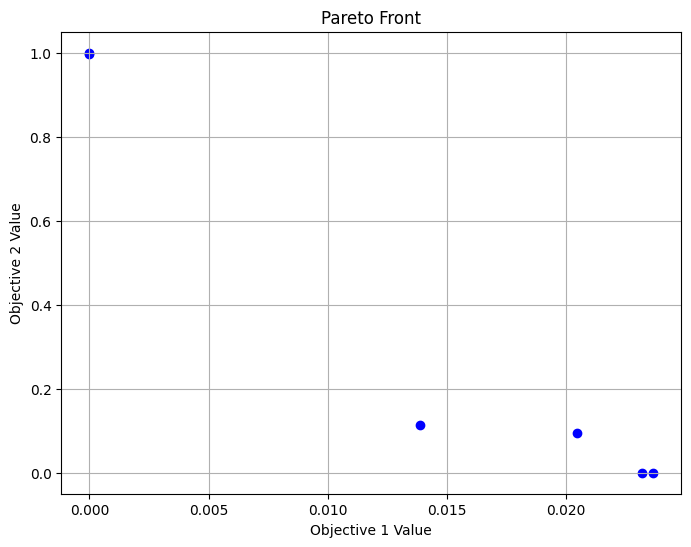

Pareto Points: [array([ 2.87365272, -0.01472646]), array([1.57534189, 1.15328067]), array([1.50136937, 1.03448095]), array([-2.58364607,  0.00613047]), array([1.46626101, 2.23347647]), array([ 1.45902409, -2.81847114])]
Pareto Values: [[ 1.30805186e-07  9.97074085e-01]
 [ 1.38775888e-02  1.13664452e-01]
 [ 2.04958613e-02  9.34460404e-02]
 [-1.09741718e-06  9.99492689e-01]
 [ 2.32027581e-02  1.58865873e-05]
 [ 2.36721958e-02  1.12821552e-08]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import EuclideanFunctionCaller
from dragonfly import multiobjective_maximise_functions  # Corrected import

# Define the objective functions
def objective_1(x):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))

def objective_2(x):
    return np.cos(5 * x[1]) * (1 - np.tanh(x[1] ** 2))

# Define the domain
domain = domains.EuclideanDomain([[-3, 3]] * 2)  # 2-dimensional domain

# List of functions to maximize
funcs = [objective_1, objective_2]

# Optimization parameters
max_capital = 50  # Maximum number of evaluations

# Execute multi-objective optimization
pareto_values, pareto_points, history = multiobjective_maximise_functions(
    funcs, domain, max_capital,
    capital_type='num_evals',
    opt_method='bo',
    config=None,
    options=None,
    reporter='default')

# Display the Pareto front
pareto_values = np.array(pareto_values)
plt.figure(figsize=(8, 6))
plt.scatter(pareto_values[:, 0], pareto_values[:, 1], c='blue', marker='o')
plt.title('Pareto Front')
plt.xlabel('Objective 1 Value')
plt.ylabel('Objective 2 Value')
plt.grid(True)
plt.show()

# Display the results
print("Pareto Points:", pareto_points)
print("Pareto Values:", pareto_values)

## Ariane

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Ariane')

In [ ]:
import os
import sys
from ariane.app.tas.utils import Scenario
import matplotlib.pyplot as plt

# Chemin complet vers le fichier JSON dans Google Colab
json_file_path = '/content/drive/MyDrive/Ariane/scenario_crystal_field_001.json'

# Chargement du scénario à partir du fichier JSON
scenario = Scenario.load(json_file_path)

# Paramètres optionnels pour l'exécution du scénario
thresh_intens = None
from ariane.app.tas.client.stubs import GPRTASClientStub
from ariane.app.tas.utils import axes_plot_labels, qe2x, Scenario
from ariane.lib.plotting import plot_function_2d
from ariane.lib.utils.math import cartesian_product, normalized_linear_interpolator

import json
import matplotlib.pyplot as plt
import numpy as np


def run_test_with_data(locs, intens, *,
                       axes, offset, limits,
                       metric=None, generate_travel_costs=True, num_rows_cols_grid_init=11,
                       level_backgr=0, thresh_intens=None, level_backgr_sim=0, with_noise=False,
                       measm_pts_max=200) -> None:
    """Run a test with given locations and intensities."""
    # change locations to server coordinates
    x = qe2x(locs, axes, offset)

    interp = normalized_linear_interpolator(x, intens)

    run_test_with_function(interp,
                           axes=axes, offset=offset, limits=limits,
                           metric=metric, generate_travel_costs=generate_travel_costs,
                           num_rows_cols_grid_init=num_rows_cols_grid_init, level_backgr=level_backgr,
                           thresh_intens=thresh_intens, level_backgr_sim=level_backgr_sim,
                           with_noise=with_noise, measm_pts_max=measm_pts_max)


def run_test_with_scenario(scenario: Scenario,
                           metric=None, generate_travel_costs=True,
                           num_rows_cols_grid_init=11, level_backgr=0, thresh_intens=None,
                           level_backgr_sim=0, with_noise=False, measm_pts_max=200) -> None:
    """Run a test with a scenario."""
    run_test_with_function(scenario.intensity_function, scenario_name=scenario.name,
                           axes=scenario.axes, offset=scenario.offset, limits=scenario.limits,
                           metric=metric if metric else scenario.angle_map_metric,
                           generate_travel_costs=generate_travel_costs, angle_map=scenario.angle_map,
                           num_rows_cols_grid_init=num_rows_cols_grid_init, level_backgr=level_backgr,
                           thresh_intens=thresh_intens, level_backgr_sim=level_backgr_sim,
                           with_noise=with_noise, measm_pts_max=measm_pts_max)


def run_test_with_function(f, *, scenario_name=None,
                           axes=None, offset=None, limits=None,
                           metric=None, generate_travel_costs=True, angle_map=None,
                           num_rows_cols_grid_init=11, level_backgr=0, thresh_intens=None,
                           level_backgr_sim=0, with_noise=False, measm_pts_max=200) -> None:
    """Run test with a given intensity function."""
    # run client stub with intensity function `f``
    client = GPRTASClientStub(intensity_function=f, scenario_name=scenario_name,
                              axes=axes, offset=offset, limits=limits,
                              metric=metric, generate_travel_costs=generate_travel_costs, angle_map=angle_map,
                              num_rows_cols_grid_init=num_rows_cols_grid_init, level_backgr=level_backgr,
                              thresh_intens=thresh_intens, level_backgr_sim=level_backgr_sim,
                              with_noise=with_noise)
    client.run(measm_pts_max=measm_pts_max)


def plot_test_data(locs, intens, *, axes, offset, limits, **kwargs):
    """Plot test run with data."""
    # change locations to server coordinates
    x = qe2x(locs, axes, offset)

    interp = normalized_linear_interpolator(x, intens)

    fig, ax = plot_test_function(interp, limits=limits, axes=axes, offset=offset, **kwargs)
    # ax.scatter(x[:, 0], x[:, 1], c='k', s=10)

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], s=1)
    plt.tight_layout()

    return fig, ax


def plot_test_scenario(scenario: Scenario, **kwargs):
    """Plot test run with a scenario."""
    return plot_test_function(f=scenario.intensity_function,
                              limits=scenario.limits,
                              axes=scenario.axes, offset=scenario.offset,
                              **kwargs)


def plot_test_function(f, *, limits, axes=None, offset=None, **kwargs):
    """Plot test run with a function."""
    if axes is not None:
        assert len(axes) == len(limits)
        if offset is not None:
            assert np.shape(axes)[1] == len(offset)

    x1_plt = np.linspace(limits[0][0], limits[0][1], num=100)
    x2_plt = np.linspace(limits[1][0], limits[1][1], num=100)

    fig, ax, _ = plot_function_2d(f, x1_plt=x1_plt, x2_plt=x2_plt,
                                  with_colorbar=True, cmap=plt.cm.jet, **kwargs)
    if axes is not None:
        x1_label, x2_label = axes_plot_labels(axes, offset=offset)
        ax.set_xlabel(x1_label)
        ax.set_ylabel(x2_label)
    ax.grid(False)

    return fig, ax


def create_file_test_data(filename, locs, intens, *, axes, offset, limits, num_pts_per_dim=30):
    # change locations to server coordinates
    x = qe2x(locs, axes, offset)

    interp = normalized_linear_interpolator(x, intens)

    create_file_test_function(filename, interp,
                              axes=axes, offset=offset, limits=limits,
                              num_pts_per_dim=num_pts_per_dim)


def create_file_test_scenario(filename, scenario: Scenario):
    create_file_test_function(filename, scenario.intensity_function,
                              axes=scenario.axes, offset=scenario.offset, limits=scenario.limits)


def create_file_test_function(filename, f, *, axes, offset, limits, num_pts_per_dim=30):
    assert len(axes) == len(limits)
    assert np.shape(axes)[1] == len(offset)

    xis = [np.linspace(start=limits[i][0], stop=limits[i][1], num=num_pts_per_dim)
           for i in range(len(limits))]
    x = np.round(cartesian_product(*xis), decimals=3)
    f = np.round([f(x_) for x_ in x], decimals=2)

    data = {'locations': x.tolist(), 'intensities': f.tolist()}

    with open(filename, 'w') as file:
        json.dump(data, file)


# Exécution du scénario avec les paramètres spécifiés
run_test_with_scenario(scenario, level_backgr=0, thresh_intens=thresh_intens,
                       level_backgr_sim=0, with_noise=False, measm_pts_max=200)


fig, ax = plot_test_scenario(scenario)
fig.tight_layout()
plt.show()

[client] Start GPRTASClientStub for scenario 'crystal_field_001'...
[client] Start GPRTASClientStub for scenario 'crystal_field_001'...
[client] Start GPRTASClientStub for scenario 'crystal_field_001'...
[client] Start GPRTASClientStub for scenario 'crystal_field_001'...
[client] Start GPRTASClientStub for scenario 'crystal_field_001'...


INFO:client:Start GPRTASClientStub for scenario 'crystal_field_001'...


[client] GPRTASClientStub started.
[client] GPRTASClientStub started.
[client] GPRTASClientStub started.
[client] GPRTASClientStub started.
[client] GPRTASClientStub started.


INFO:client:GPRTASClientStub started.


[client] Sent: [b'ARIANE', b'', b'ping']
[client] Sent: [b'ARIANE', b'', b'ping']
[client] Sent: [b'ARIANE', b'', b'ping']
[client] Sent: [b'ARIANE', b'', b'ping']
[client] Sent: [b'ARIANE', b'', b'ping']


INFO:client:Sent: [b'ARIANE', b'', b'ping']


KeyboardInterrupt: 

In [ ]:
!git clone https://jugit.fz-juelich.de/ainx/ariane.git

Cloning into 'ariane'...
remote: Enumerating objects: 5634, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 5634 (delta 127), reused 276 (delta 119), pack-reused 5331
Receiving objects: 100% (5634/5634), 3.34 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (3200/3200), done.


In [ ]:
!pip install -r ariane/requirements.txt

In [ ]:
!python ariane/tests/automated/test_gpr.py
!python ariane/tests/automated/test_math.py
!python ariane/tests/automated/test_tas.py

In [ ]:
!python -m unittest discover -v -s ariane/tests -p '_init_.py'


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


In [ ]:
!python ariane/tests/manual/tas/test_scenario.py

[client] Start GPRTASClientStub for scenario 'crystal_field_001'...
[client] GPRTASClientStub started.
[client] Sent: [b'ARIANE', b'', b'ping']


In [ ]:
!pip install --upgrade ariane

In [ ]:
from ariane.lib.gaussian_process_regression import LogGaussianProcessRegressor
from ariane.lib.gaussian_process_regression._gpr import noise_from_log, noise_to_log
from ariane.lib.gaussian_process_regression.implementations.sklearn import ScikitLearnGaussianProcessRegressor
from ariane.lib.gaussian_process_regression.implementations.sklearn.kernels import ConstantKernel as C, RBF
from ariane.lib.utils import math

import numpy as np
import unittest


class TestScikitLearnGaussianProcessRegressor(unittest.TestCase):
    def f_1D(self, x):
        return np.sin(2*np.pi*x)

    def f_2D(self, x):
        x1, x2, = x[0], x[1]
        return np.sin(2*np.pi*x1) * np.sin(2*np.pi*x2)

    def test_add_data_1D(self):
        x = np.linspace(0, 1, num=10)
        x_ = x[:, np.newaxis]
        f = self.f_1D(x)

        kernel = C()*RBF()
        gpr = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, noise=1e-3, n_restarts_optimizer=100, normalize_y=False)
        gpr.fit(x_, f)

        gpr = self.set_up_gpr_1D()

        # Tracé des résultats après l'ajout des données
        x_plot = np.linspace(0, 1, 100)[:, np.newaxis]
        y_pred, y_std = gpr.predict(x_plot, return_std=True)
        y_true = self.f_1D(x_plot.flatten())

        plt.figure(figsize=(12, 6))
        plt.plot(x_plot.flatten(), y_true, 'r-', label='True function')
        plt.scatter(gpr.x_train.flatten(), gpr.y_train, c='b', label='Training points')
        plt.plot(x_plot.flatten(), y_pred, 'k-', label='GPR prediction')
        plt.fill_between(x_plot.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, label='Standard deviation')
        plt.legend()
        plt.show()
        self.plot_results_1D(gpr)

    def set_up_gpr_1D(self):
        # Cette méthode configure et renvoie un objet GPR ajusté
        x = np.linspace(0, 1, num=10)
        x_ = x[:, np.newaxis]
        f = self.f_1D(x)

        kernel = C()*RBF()
        gpr = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, noise=1e-3, n_restarts_optimizer=100, normalize_y=False)
        gpr.fit(x_, f)
        return gpr

    def plot_results_1D(self, gpr):
        # Cette méthode génère un graphique des résultats du GPR
        x_plot = np.linspace(0, 1, 100)[:, np.newaxis]
        y_pred, y_std = gpr.predict(x_plot, return_std=True)
        y_true = self.f_1D(x_plot.flatten())

        plt.figure(figsize=(12, 6))
        plt.plot(x_plot.flatten(), y_true, 'r-', label='True function')
        plt.scatter(gpr.x_train.flatten(), gpr.y_train, c='b', label='Training points')
        plt.plot(x_plot.flatten(), y_pred, 'k-', label='GPR prediction')
        plt.fill_between(x_plot.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, label='Standard deviation')
        plt.legend()
        plt.show()



    def test_add_data_2D(self):
        x1s = np.linspace(0, 1, num=10)
        x2s = x1s
        x = math.cartesian_product(x1s, x2s)
        f = [self.f_2D(x_) for x_ in x]

        kernel = C()*RBF()
        gpr = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, noise=1e-3, n_restarts_optimizer=100, normalize_y=False)
        gpr.fit(x, f)

        x_new = [0.15, 0.15]
        f_new = self.f_2D(x_new)
        gpr.add_data(np.atleast_2d(x_new), np.atleast_1d(f_new))

        self.assertTrue(np.allclose(gpr.x_train, np.append(x, [x_new], axis=0)))
        self.assertTrue(np.allclose(gpr.y_train, np.append(f, f_new)))

    def test_add_data_update_cholesky_decomp(self):
        x = np.linspace(0, 1, num=6)
        f = self.f_1D(x)
        x = x[:, np.newaxis]

        kernel = C()*RBF()
        gpr = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, noise=1e-3, n_restarts_optimizer=100, normalize_y=False)
        gpr.fit(x, f)

        gpr.stop_optimization()

        x_new = np.array([0.5, 0.6, 0.75])
        f_new = self.f_1D(x_new)
        x_new = x_new[:, np.newaxis]
        gpr.add_data(x_new, f_new)

        x = np.append(x, x_new, axis=0)
        f = np.append(f, f_new)

        gpr2 = ScikitLearnGaussianProcessRegressor(
            kernel=gpr.kernel, noise=1e-3, optimizer=None, normalize_y=False)
        gpr2.fit(x, f)

        self.assertTrue(np.allclose(gpr.gpr.L_, gpr2.gpr.L_))
        self.assertTrue(np.allclose(gpr.gpr.alpha_, gpr2.gpr.alpha_))


class TestLogGaussianProcessRegressor(unittest.TestCase):
    def f_1D(self, x):
        amp = 400
        return amp*np.exp(-0.5*(x-0.5)**2*amp)

    def f_2D(self, x):
        amp = 400
        x1, x2 = x[0], x[1]
        return amp*np.exp(-0.5*((x1-0.5)**2*np.sqrt(amp) + (x2-0.5)**2*np.sqrt(amp)))

    def test_add_data_1D(self):
        x = np.linspace(0, 1, num=10)
        x_ = x[:, np.newaxis]
        f = self.f_1D(x)

        kernel = C()*RBF()
        gpr_impl = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, n_restarts_optimizer=100, normalize_y=False)
        lgpr = LogGaussianProcessRegressor(gpr_impl)
        lgpr.fit(x_, f, noise=f)

        x_new = 0.15
        f_new = self.f_1D(x_new)
        lgpr.add_data(np.atleast_2d(x_new), np.atleast_1d(f_new), noise=np.atleast_1d(f_new))

        self.assertTrue(np.allclose(lgpr.x_train, np.append(x_, [[x_new]], axis=0)))
        self.assertTrue(np.allclose(lgpr.y_train, np.append(f, f_new)))

    def test_add_data_2D(self):
        x1s = np.linspace(0, 1, num=10)
        x2s = x1s
        x = math.cartesian_product(x1s, x2s)
        f = [self.f_2D(x_) for x_ in x]

        kernel = C()*RBF()
        gpr_impl = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, noise=1e-6, n_restarts_optimizer=30, normalize_y=False)
        lgpr = LogGaussianProcessRegressor(gpr_impl)
        lgpr.fit(x, f, noise=f)

        x_new = [0.15, 0.15]
        f_new = self.f_2D(x_new)
        lgpr.add_data(np.atleast_2d(x_new), np.atleast_1d(f_new), noise=np.atleast_1d(f_new))

        self.assertTrue(np.allclose(lgpr.x_train, np.append(x, [x_new], axis=0)))
        self.assertTrue(np.allclose(lgpr.y_train, np.append(f, f_new)))

    def test_transform_noise(self):
        x = np.linspace(0, 1, num=10)
        x_ = x[:, np.newaxis]
        f = self.f_1D(x)

        kernel = C()*RBF()
        gpr_impl = ScikitLearnGaussianProcessRegressor(
            kernel=kernel, n_restarts_optimizer=100, normalize_y=False)
        lgpr = LogGaussianProcessRegressor(gpr_impl)
        lgpr.fit(x_, f, noise=f)

        self.assertTrue(np.allclose(
            noise_to_log(noise_from_log(lgpr.noise, lgpr.y_train), lgpr.y_train),
            lgpr.noise))
        self.assertTrue(np.allclose(
            noise_from_log(noise_to_log(lgpr.gpr.noise, lgpr.y_train), lgpr.y_train),
            lgpr.gpr.noise))



In [ ]:
if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...E..
ERROR: test_add_data_1D (__main__.TestScikitLearnGaussianProcessRegressor)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-49-3e12c0610b9f>", line 33, in test_add_data_1D
    y_pred, y_std = gpr.predict(x_plot, return_std=True)
AttributeError: 'ScikitLearnGaussianProcessRegressor' object has no attribute 'predict'

----------------------------------------------------------------------
Ran 6 tests in 29.255s

FAILED (errors=1)


# Multivariate normal

- 1D

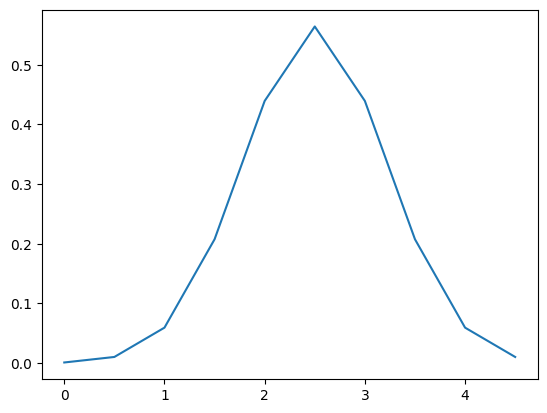

In [ ]:
from scipy.stats import multivariate_normal
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5); np.array([ 0.00108914,  0.01033349,  0.05946514,  0.20755375,  0.43939129,
        0.56418958,  0.43939129,  0.20755375,  0.05946514,  0.01033349])
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)
plt.show()

 - 2D

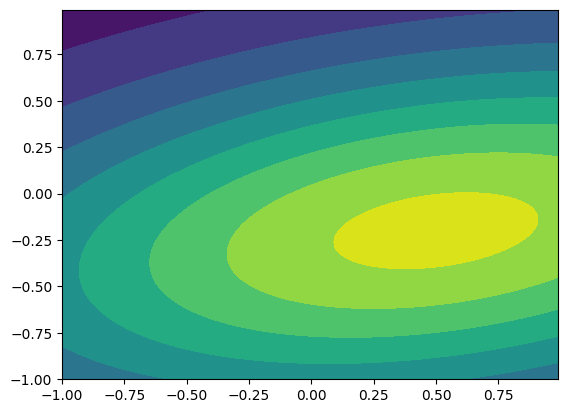

In [ ]:
rv = multivariate_normal(mean=None, cov=1, allow_singular=False)

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

## Optimisation Bayésienne

### 1.Scipy

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# Objective function as the negative PDF to minimize
def objective_function(x):
    rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
    return -rv.pdf(x)

# Starting point
initial_guess = [0, 0]

# Minimization using the negative PDF
res = minimize(objective_function, initial_guess, method='L-BFGS-B', bounds=[(-1, 1), (-1, 1)])

# Maximum location
max_location = res.x
max_value = -res.fun

print(f"Maximum value of the PDF is {max_value} at location {max_location}")

Maximum value of the PDF is 0.1668397135323422 at location [ 0.50000196 -0.19999908]


### 2.Dragonfly

In [ ]:
import numpy as np
import numpy as np
np.int = int  # Alias temporaire pour éviter l'erreur dans dragonfly

from scipy.stats import multivariate_normal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller
from dragonfly import maximise_function

# Définition de la classe ScikitLearnGaussianProcessRegressor
class ScikitLearnGaussianProcessRegressor:
    def __init__(self, kernel, n_restarts_optimizer=0):
        # Initialisation du GPR avec le kernel spécifié et le nombre de redémarrages
        self.gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, y):
        # Méthode pour entraîner le modèle
        self.gpr.fit(X, y)

    def predict(self, X, return_std=False):
        # Méthode pour réaliser des prédictions
        return self.gpr.predict(X, return_std=return_std)

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    x = np.array(x, dtype=np.float64).flatten()
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Configuration du domaine pour les variables
domain_bounds = [{'name': 'var_1', 'type': 'float', 'min': -1, 'max': 1},
                 {'name': 'var_2', 'type': 'float', 'min': -1, 'max': 1}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Adapter la classe pour l'optimisation
class ModelAdapter:
    def __init__(self, model):
        self.model = model

    def evaluate(self, x):
        x_reshaped = np.array(x, dtype=np.float64).reshape(1, -1)
        return self.model.predict(x_reshaped, return_std=False)[0]

# Initialisation de la classe avec le kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
ariane_gpr = ScikitLearnGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Exemple de données pour l'entraînement
X_sample = np.random.rand(10, 2).astype(np.float64)
y_sample = np.array([objective_function(x) for x in X_sample], dtype=np.float64)

# Entraînement du modèle
ariane_gpr.fit(X_sample, y_sample)

# Création de l'instance de l'adaptateur et configuration du CPFunctionCaller
adapted_model = ModelAdapter(ariane_gpr)
func_caller = CPFunctionCaller(adapted_model.evaluate, domain_obj)

# Exécution de l'optimisation Bayésienne
opt_val, opt_pt, history = maximise_function(func_caller.func, func_caller.domain, max_capital=100)

# Affichage des résultats
print(f"The maximum value of the PDF is {opt_val} at the point {opt_pt}")

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 100.0 (return_value)
Capital spent on initialisation: 8.0000(0.0800).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.110):: curr_max=0.16795, acqs=[ei:0, ucb:1, ttei:1, add_ucb:1], 
#026 (024, 0.240):: curr_max=0.17717, acqs=[ei:2, ucb:7, ttei:4, add_ucb:3], 
#039 (037, 0.370):: curr_max=0.17725, acqs=[ei:4, ucb:13, ttei:7, add_ucb:5], 
#052 (050, 0.500):: curr_max=0.17726, acqs=[ei:6, ucb:17, ttei:10, add_ucb:9], 
#065 (063, 0.630):: curr_max=0.17727, acqs=[ei:7, ucb:23, ttei:12, add_ucb:13], 
#078 (076, 0.760):: curr_max=0.17727, acqs=[ei:12, ucb:28, ttei:14, add_ucb:14], 
#091 (089, 0.890):: curr_max=0.17727, acqs=[ei:18, ucb:29, ttei:17, add_ucb:17], 
#102 (101, 1.010):: curr_max=0.17727, acqs=[ei:20, ucb:31, ttei:20, add_ucb:22], 
The maximum value of the PDF is 0.17727489026831478 at the point [ 0.3

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 100.0 (return_value)
Capital spent on initialisation: 8.0000(0.0800).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.110):: curr_max=0.16849, acqs=[ei:2, ucb:0, ttei:1, add_ucb:0], 
#026 (024, 0.240):: curr_max=0.17027, acqs=[ei:8, ucb:2, ttei:2, add_ucb:4], 
#039 (037, 0.370):: curr_max=0.17029, acqs=[ei:14, ucb:3, ttei:7, add_ucb:5], 
#052 (050, 0.500):: curr_max=0.17029, acqs=[ei:19, ucb:4, ttei:10, add_ucb:9], 
#065 (063, 0.630):: curr_max=0.17029, acqs=[ei:25, ucb:4, ttei:15, add_ucb:11], 
#078 (076, 0.760):: curr_max=0.17029, acqs=[ei:33, ucb:6, ttei:16, add_ucb:13], 
#091 (089, 0.890):: curr_max=0.17029, acqs=[ei:39, ucb:8, ttei:18, add_ucb:16], 
#102 (101, 1.010):: curr_max=0.17029, acqs=[ei:45, ucb:9, ttei:22, add_ucb:17], 


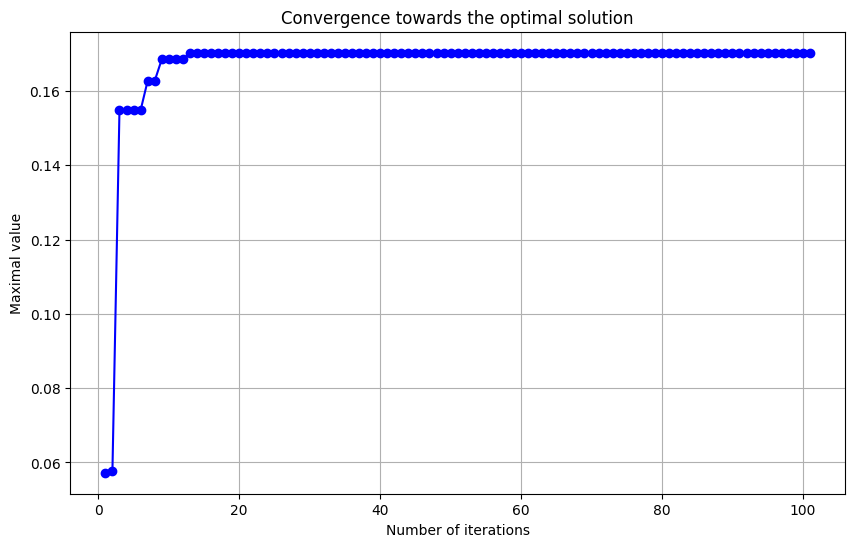

The maximum value of the PDF is 0.1702895337855268 at the point [ 0.53267625 -0.26391641].


In [ ]:
import numpy as np
import numpy as np
np.int = int  # Alias temporaire pour éviter l'erreur dans dragonfly

from scipy.stats import multivariate_normal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller
from dragonfly import maximise_function
import matplotlib.pyplot as plt

# Définition de la classe ScikitLearnGaussianProcessRegressor
class ScikitLearnGaussianProcessRegressor:
    def __init__(self, kernel, n_restarts_optimizer=0):
        # Initialisation du GPR avec le kernel spécifié et le nombre de redémarrages
        self.gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, y):
        # Méthode pour entraîner le modèle
        self.gpr.fit(X, y)

    def predict(self, X, return_std=False):
        # Méthode pour réaliser des prédictions
        return self.gpr.predict(X, return_std=return_std)

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    x = np.array(x, dtype=np.float64).flatten()
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Configuration du domaine pour les variables
domain_bounds = [{'name': 'var_1', 'type': 'float', 'min': -1, 'max': 1},
                 {'name': 'var_2', 'type': 'float', 'min': -1, 'max': 1}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Adapter la classe pour l'optimisation
class ModelAdapter:
    def __init__(self, model):
        self.model = model

    def evaluate(self, x):
        x_reshaped = np.array(x, dtype=np.float64).reshape(1, -1)
        return self.model.predict(x_reshaped, return_std=False)[0]

# Initialisation de la classe avec le kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
ariane_gpr = ScikitLearnGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Exemple de données pour l'entraînement
X_sample = np.random.rand(10, 2).astype(np.float64)
y_sample = np.array([objective_function(x) for x in X_sample], dtype=np.float64)

# Entraînement du modèle
ariane_gpr.fit(X_sample, y_sample)

# Création de l'instance de l'adaptateur et configuration du CPFunctionCaller
adapted_model = ModelAdapter(ariane_gpr)
func_caller = CPFunctionCaller(adapted_model.evaluate, domain_obj)

# Exécution de l'optimisation Bayésienne
opt_val, opt_pt, history = maximise_function(func_caller.func, func_caller.domain, max_capital=100)

optimal_values = history.curr_opt_vals

# Affiche la convergence dans un graphique
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(optimal_values) + 1), optimal_values, marker='o', linestyle='-', color='b')
plt.title('Convergence towards the optimal solution')
plt.xlabel('Number of iterations')
plt.ylabel('Maximal value')
plt.grid(True)
plt.show()

# Affiche les résultats
print(f"The maximum value of the PDF is {opt_val} at the point {opt_pt}.")

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 100.0 (return_value)
Capital spent on initialisation: 8.0000(0.0800).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.110):: curr_max=0.16580, acqs=[ei:0, ucb:1, ttei:2, add_ucb:0], 
#026 (024, 0.240):: curr_max=0.16988, acqs=[ei:2, ucb:5, ttei:3, add_ucb:6], 
#039 (037, 0.370):: curr_max=0.16988, acqs=[ei:4, ucb:7, ttei:7, add_ucb:11], 
#052 (050, 0.500):: curr_max=0.16989, acqs=[ei:7, ucb:9, ttei:10, add_ucb:16], 
#065 (063, 0.630):: curr_max=0.16989, acqs=[ei:9, ucb:12, ttei:11, add_ucb:23], 
#078 (076, 0.760):: curr_max=0.16989, acqs=[ei:11, ucb:15, ttei:12, add_ucb:30], 
#091 (089, 0.890):: curr_max=0.16989, acqs=[ei:11, ucb:18, ttei:16, add_ucb:36], 
#102 (101, 1.010):: curr_max=0.16989, acqs=[ei:13, ucb:21, ttei:18, add_ucb:41], 


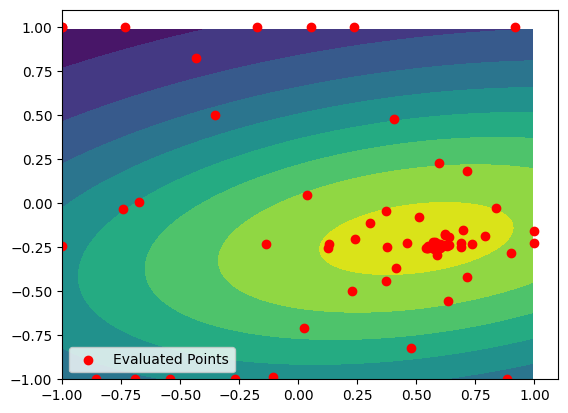

In [ ]:
import numpy as np
np.int = int
from scipy.stats import multivariate_normal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller
from dragonfly import maximise_function
import matplotlib.pyplot as plt

# Définition de la classe ScikitLearnGaussianProcessRegressor
class ScikitLearnGaussianProcessRegressor:
    def __init__(self, kernel, n_restarts_optimizer=0):
        self.gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, y):
        self.gpr.fit(X, y)

    def predict(self, X, return_std=False):
        return self.gpr.predict(X, return_std=return_std)

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    x = np.array(x, dtype=np.float64).flatten()
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Configuration du domaine pour les variables
domain_bounds = [{'name': 'var_1', 'type': 'float', 'min': -1, 'max': 1},
                 {'name': 'var_2', 'type': 'float', 'min': -1, 'max': 1}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Adapter la classe pour l'optimisation
class ModelAdapter:
    def __init__(self, model):
        self.model = model

    def evaluate(self, x):
        x_reshaped = np.array(x, dtype=np.float64).reshape(1, -1)
        return self.model.predict(x_reshaped, return_std=False)[0]

# Initialisation de la classe avec le kernel
kernel = C(1.0, (1e-6, 1e3)) * RBF(1.0, (1e-3, 1e2))
ariane_gpr = ScikitLearnGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Exemple de données pour l'entraînement
X_sample = np.random.rand(10, 2) * 2 - 1  # Samples within the domain bounds
y_sample = np.array([objective_function(x) for x in X_sample], dtype=np.float64)

# Entraînement du modèle
ariane_gpr.fit(X_sample, y_sample)

# Création de l'instance de l'adaptateur et configuration du CPFunctionCaller
adapted_model = ModelAdapter(ariane_gpr)
func_caller = CPFunctionCaller(adapted_model.evaluate, domain_obj)

# Exécution de l'optimisation Bayésienne
opt_val, opt_pt, history = maximise_function(func_caller.func, func_caller.domain, max_capital=100)

optimal_values = history.curr_opt_vals

# Récupération des points évalués pendant l'optimisation
evaluated_points = np.array([pt for pt in history.query_points])

# Assurez-vous que evaluated_points est un tableau 2D
if len(evaluated_points.shape) == 1:
    # Reshape evaluated_points to be a 2D array with one column
    evaluated_points = evaluated_points.reshape(-1, 1)

# Création d'un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
pos = np.dstack((x, y))
mean = np.array([0.5, -0.2], dtype=np.float64)
cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajout des points évalués sur le plot
# Vérifiez si evaluated_points a plus d'une colonne avant de tracer
if evaluated_points.shape[1] > 1:
    ax.scatter(evaluated_points[:, 0], evaluated_points[:, 1], color='r', label='Evaluated Points')
else:
    # Si evaluated_points n'a qu'une seule colonne, plottez-la contre elle-même
    ax.scatter(evaluated_points[:, 0], evaluated_points[:, 0], color='r', label='Evaluated Points')

# Ajout d'une légende
ax.legend()

# Affichage du plot
plt.show()

### 3.BoFire

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.domain.api import Inputs, Outputs, Domain
from bofire.data_models.constraints.api import LinearEqualityConstraint, LinearInequalityConstraint
from bofire.optimization_strategies.api import SoboStrategy
from bofire.acquisition_functions import qNEI
import matplotlib.pyplot as plt

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Caractéristiques d'entrée (basées sur la dimensionnalité des données)
x1 = ContinuousInput(key="x1", bounds=(-3, 3))
x2 = ContinuousInput(key="x2", bounds=(-3, 3))

# Caractéristique de sortie
y1 = ContinuousOutput(key="y1")

# Définition des contraintes
constraints = [LinearEqualityConstraint(features=["x1", "x2"], coefficients=[1, 1], rhs=1),
               LinearInequalityConstraint(features=["x1", "x2"], coefficients=[1, 2], rhs=0.8)]

# Création des conteneurs d'entrées et de sorties
input_features = Inputs(features=[x1, x2])
output_features = Outputs(features=[y1])

# Création du domaine d'optimisation
domain = Domain(inputs=input_features, outputs=output_features, constraints=constraints)

# Définition de la stratégie SOBO
sobo_strategy = SoboStrategy(data_model=domain, acquisition_function=qNEI())

# Génération de données initiales
initial_samples = domain.inputs.sample(n=5)

# Entraînement de la stratégie SOBO avec les données initiales
sobo_strategy.tell(experiments=initial_samples)

# Exécution de l'optimisation bayésienne
for i in range(100):  # Nombre d'itérations
    new_candidate = sobo_strategy.ask(candidate_count=1)
    objective_value = objective_function([new_candidate["x1"], new_candidate["x2"]])
    sobo_strategy.tell(experiments=np.array([[new_candidate["x1"], new_candidate["x2"], objective_value]]))

# Récupération de l'historique des valeurs optimales
optimal_values = [entry[2] for entry in sobo_strategy.data_model.objectives.data]

# Affiche la convergence dans un graphique
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(optimal_values) + 1), optimal_values, marker='o', linestyle='-', color='b')
plt.title('Convergence vers la solution optimale')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Valeur maximale')
plt.grid(True)
plt.show()

# Affiche les résultats
print(f"La valeur maximale de la PDF est {max(optimal_values)}")

ModuleNotFoundError: No module named 'bofire.optimization_strategies'

### 4.Scikit

In [ ]:
!pip install scikit-optimize

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from skopt import gp_minimize

# Définition de la fonction objectif basée sur la distribution normale multivariée
def objective_function(x):
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    mvn = multivariate_normal(mean, cov)
    return -mvn.pdf(x)  # On utilise le négatif car skopt minimise par défaut

# Définition des bornes pour skopt
bounds = [(-3, 3), (-3, 3)]

# Optimisation bayésienne avec skopt
skopt_result = gp_minimize(objective_function, bounds, n_calls=10, random_state=42)

print("Meilleurs paramètres avec skopt:", skopt_result.x)
print("Meilleure valeur avec skopt:", -skopt_result.fun)

### 5.BoTorch

In [ ]:
!pip install botorch gpytorch

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils import standardize
from botorch.utils.multi_objective import infer_reference_point
from botorch.utils.multi_objective.box_decompositions import NondominatedPartitioning

# Définition de la fonction objectif multi-objectifs
def evaluate_objective(X):
    f1 = (X[..., 0] - 0.5) ** 2
    f2 = (X[..., 0] + 0.5) ** 2
    return torch.stack([-f1, -f2], dim=-1)  # Maximisation en multi-objectifs

# Génération de données initiales
train_X = torch.rand(10, 1)
train_Y = evaluate_objective(train_X)

# Normalisation des entrées et sorties
bounds = torch.tensor([[0.], [1.]])
train_X_normalized = normalize(train_X, bounds=bounds)
train_Y_standardized = standardize(train_Y)

# Définition et ajustement du modèle GP
model = SingleTaskGP(train_X_normalized, train_Y_standardized)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Définition de la fonction d'acquisition
hv_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([1]))
ref_point = infer_reference_point(train_Y_standardized)
partitioning = NondominatedPartitioning(Y=train_Y_standardized, ref_point=ref_point)

acq_func = qExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point.tolist(),
    sampler=hv_sampler,
    partitioning=partitioning
)

# Optimisation de la fonction d'acquisition
batch_size = 1
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=batch_size,
    num_restarts=5,
    raw_samples=20,
)

# Dénormalisation de la solution candidate
candidate_denormalized = unnormalize(candidate, bounds=bounds)
print("Solution candidate (dénormalisée) :", candidate_denormalized)

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils import standardize

# Set default tensor type to double precision
torch.set_default_dtype(torch.float64)

# Definition of the multi-objective function
def evaluate_objective(X):
    mean = torch.tensor([0.5, -0.2])
    cov = torch.tensor([[2.0, 0.3], [0.3, 0.5]])
    rv = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    return -rv.log_prob(X)  # Negative because we are maximizing

# Generating initial data
train_X = torch.rand(10, 2).double()
train_Y = torch.stack([evaluate_objective(x) for x in train_X]).unsqueeze(-1).double()

# Normalizing inputs and outputs
bounds = torch.tensor([[0.0, 0.0], [1.0, 1.0]])
train_X_normalized = normalize(train_X, bounds=bounds)
train_Y_standardized = standardize(train_Y)

# Ensure train_Y_standardized has the correct shape
if train_Y_standardized.ndim != 2:
    train_Y_standardized = train_Y_standardized.view(-1, 1)

# Defining and fitting the GP model
model = SingleTaskGP(train_X_normalized, train_Y_standardized)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Créer la fonction d'acquisition Expected Improvement
acq_func = ExpectedImprovement(model=model, best_f=train_Y_standardized.max())

# Optimiser la fonction d'acquisition
batch_size = 1
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=batch_size,
    num_restarts=5,
    raw_samples=20,
)

# Denormalizing the candidate solution
candidate_denormalized = unnormalize(candidate, bounds=bounds)
print("Candidate solution (denormalized):", candidate_denormalized)

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils import standardize

torch.set_default_dtype(torch.float64)

def evaluate_objective(X):
    mean = torch.tensor([0.5, -0.2])
    cov = torch.tensor([[2.0, 0.3], [0.3, 0.5]])
    rv = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    return rv.log_prob(X)  # We use log probability for numerical stability

# Generating initial data
train_X = torch.rand(10, 2).double()
train_Y = torch.stack([evaluate_objective(x) for x in train_X]).unsqueeze(-1).double()

# Normalizing inputs and outputs
bounds = torch.tensor([[0.0, 0.0], [1.0, 1.0]])
train_X_normalized = normalize(train_X, bounds=bounds)
train_Y_standardized = standardize(train_Y)

if train_Y_standardized.ndim != 2:
    train_Y_standardized = train_Y_standardized.view(-1, 1)

# Defining and fitting the GP model
model = SingleTaskGP(train_X_normalized, train_Y_standardized)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Defining an acquisition function to maximize the GP output directly
acq_func = UpperConfidenceBound(model=model, beta=2.0)

# Optimizing the acquisition function
batch_size = 1
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=batch_size,
    num_restarts=5,
    raw_samples=20,
)

# Denormalizing the candidate solution
candidate_denormalized = unnormalize(candidate, bounds=bounds)
print("Candidate solution (denormalized):", candidate_denormalized)

In [ ]:
import torch

# Set default tensor type to double precision
torch.set_default_dtype(torch.float64)

# Definition of the multi-objective function
def evaluate_pdf(X):
    mean = torch.tensor([0.5, -0.2])
    cov = torch.tensor([[2.0, 0.3], [0.3, 0.5]])
    rv = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    return torch.exp(rv.log_prob(X))  # Directly computing the PDF

# Generate a grid of points to sample the PDF
num_points = 100
x1 = torch.linspace(0, 1, num_points)
x2 = torch.linspace(0, 1, num_points)
grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
grid_points = torch.stack([grid_x1, grid_x2], dim=-1).view(-1, 2)

# Evaluate the PDF at each point
pdf_values = evaluate_pdf(grid_points)

# Find the maximum PDF value and the corresponding point
max_pdf, max_index = torch.max(pdf_values, dim=0)
max_point = grid_points[max_index]

print("Maximum PDF value:", max_pdf.item())
print("Point with maximum PDF:", max_point.numpy())

### Mix

#### Ariane et Dragonfly

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from ariane.regression import LogGaussianProcessRegressor
from dragonfly import maximise_function

# Données du modèle multivarié
mean = np.array([0.5, -0.2], dtype=np.float64)
cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
mvn = multivariate_normal(mean, cov)

# Définition de la fonction objectif basée sur la distribution normale multivariée
def objective_function(x):
    return mvn.pdf(x)

# Entraînement du modèle de régression avec Ariane
regressor = LogGaussianProcessRegressor(
    input_dim=2,          # Dimension de l'espace des paramètres
    num_epochs=100,       # Nombre d'époques d'entraînement
    num_restarts=5,       # Nombre de redémarrages pour l'optimisation des hyperparamètres
    seed=42,              # Graine aléatoire pour la reproductibilité
)
regressor.fit(X=[], Y=[], noise=1e-6)  # On ajuste un modèle vide pour l'instant

# Définition de la fonction à maximiser pour Dragonfly
def dragonfly_objective(x):
    return -objective_function(x)  # On utilise le négatif car Dragonfly minimise par défaut

# Définition des bornes pour Dragonfly
bounds = [(lb, ub) for lb, ub in zip([-3, -3], [3, 3])]

# Optimisation avec Dragonfly
results = maximise_function(func=dragonfly_objective, domain=bounds, max_capital=10)

# Affichage des résultats
print("Meilleurs paramètres avec Dragonfly:", results)


ModuleNotFoundError: No module named 'ariane.regression'

#### BoFire et Dragonfly

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from bofire.strategies.api import SoboStrategy
from bofire.data_models.domain.api import Inputs, Outputs, Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.objectives.api import MinimizeObjective
from bofire.plot.api import plot_objective_plotly
from dragonfly.exd import domains
from dragonfly import maximise_function
import matplotlib.pyplot as plt

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    x = np.array(x, dtype=np.float64).flatten()
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return -rv.pdf(x)  # On minimise plutôt que de maximiser

# Configuration du domaine pour les variables
domain_bounds = [{'name': 'x1', 'type': 'float', 'min': -3, 'max': 3},
                 {'name': 'x2', 'type': 'float', 'min': -3, 'max': 3}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Définition des caractéristiques d'entrée et de sortie pour BoFIRE
x1 = ContinuousInput(key="x1", bounds=(-3, 3))
x2 = ContinuousInput(key="x2", bounds=(-3, 3))
y1 = ContinuousOutput(key="y1")

# Création du domaine d'optimisation pour BoFIRE
input_features = Inputs(features=[x1, x2])
output_features = Outputs(features=[y1])
domain_bofire = Domain(inputs=input_features, outputs=output_features)

# Configuration de la stratégie SOBO pour BoFIRE
sobo_strategy = SoboStrategy(data_model=domain_bofire, acquisition_function="qNEI")

# Adaptation de Dragonfly à BoFIRE
class DragonflyFunctionAdapter:
    def __init__(self, sobo_strategy):
        self.sobo_strategy = sobo_strategy

    def evaluate(self, x):
        return self.sobo_strategy.ask(x)[0]

# Création de l'instance de l'adaptateur
func_caller = DragonflyFunctionAdapter(sobo_strategy)

# Exécution de l'optimisation Bayésienne avec Dragonfly
opt_val, opt_pt, history = maximise_function(func_caller.evaluate, domain_obj, max_capital=100)

# Affiche les résultats
print(f"La valeur maximale de la PDF est {-opt_val} au point {opt_pt}")

# Extrait les données d'optimalité de l'historique
optimal_values = [-entry[1] for entry in history]

# Affiche la convergence dans un graphique
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(optimal_values) + 1), optimal_values, marker='o', linestyle='-', color='b')
plt.title('Convergence vers la solution optimale')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Valeur maximale')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from bofire.data_models.api import DataModel
from bofire.strategies.api import SoboStrategy
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.domain.api import Inputs, Outputs, Domain
from bofire.data_models.constraints.api import LinearEqualityConstraint, LinearInequalityConstraint

# Définition de la fonction objective utilisant la distribution normale multivariée
def objective_function(x):
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Caractéristiques d'entrée (basées sur la dimensionnalité des données)
x1 = ContinuousInput(key="x1", bounds=(-3, 3))
x2 = ContinuousInput(key="x2", bounds=(-3, 3))

# Caractéristique de sortie
y1 = ContinuousOutput(key="y1")

# Définition des contraintes
constr1 = LinearEqualityConstraint(features=["x1", "x2"], coefficients=[1, 1], rhs=1)
constr2 = LinearInequalityConstraint(features=["x1", "x2"], coefficients=[1, 2], rhs=0.8)

# Création des conteneurs d'entrées et de sorties
input_features = Inputs(features=[x1, x2])
output_features = Outputs(features=[y1])

# Création du domaine d'optimisation
domain = Domain(inputs=input_features, outputs=output_features, constraints=[constr1, constr2])

# Création du modèle de données à partir du domaine
data_model = DataModel.from_domain(domain)

# Définition de la stratégie SOBO
sobo_strategy_data_model = SoboStrategy(data_model=data_model)

# Génération de données initiales
initial_samples = data_model.sample(n=5)

# Entraînement de la stratégie SOBO avec les données initiales
sobo_strategy_data_model.tell(experiments=initial_samples)

# Demander une nouvelle suggestion
new_candidate = sobo_strategy_data_model.ask(candidate_count=1)
print("Nouvelle suggestion :", new_candidate)

## TAS

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class TestSystem:
    def __init__(self):
        self.optimizer = None  # L'optimiseur sera configuré plus tard

    def setup_optimizer(self, optimizer):
        self.optimizer = optimizer

    def run_test(self, x):
        if self.optimizer:
            return self.optimizer(x)
        else:
            raise ValueError("Optimizer not set up.")

class TestCase:
    def __init__(self, name, system, mean, cov):
        self.name = name
        self.system = system
        self.mean = mean
        self.cov = cov
        self.mvn = multivariate_normal(mean, cov)

    def run(self):
        # Définition de la fonction objectif pour ce cas spécifique
        def objective_function(x):
            return self.mvn.pdf(x)

        # Configuration de l'optimiseur avec la fonction objectif
        self.system.setup_optimizer(objective_function)

        # Simuler un processus de test, ici en choisissant un point aléatoire
        test_point = np.random.multivariate_normal(self.mean, self.cov, 1)
        result = self.system.run_test(test_point)

        return result

# Création du système de test
test_system = TestSystem()

# Définition des paramètres de la distribution normale multivariée
mean = np.array([0.5, -0.2])
cov = np.array([[2.0, 0.3], [0.3, 0.5]])

# Création du cas de test
test_case = TestCase("Optimization Test", test_system, mean, cov)

# Exécution du test
result = test_case.run()

print("Résultat du test :", result)

Résultat du test : 0.1409408008134876


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianProcessTAS:
    def __init__(self, mean, covariance):
        self.mean = mean
        self.covariance = covariance
        self.distribution = multivariate_normal(mean, covariance)

    def objective_function(self, x):
        """La fonction que nous souhaitons maximiser, la densité de probabilité de la distribution."""
        return self.distribution.pdf(x)

    def run_optimization(self, optimizer):
        """Exécute l'optimiseur sur la fonction objectif."""
        result = optimizer.optimize(self.objective_function, self.mean - 3, self.mean + 3)
        return result

# Exemple de configuration de l'optimiseur (hypothétique)
class BayesianOptimizer:
    def __init__(self, iterations=10):
        self.iterations = iterations

    def optimize(self, func, lower_bounds, upper_bounds):
        """Simuler un processus d'optimisation bayésienne."""
        current_best = None
        current_best_value = float('-inf')
        for _ in range(self.iterations):
            x = np.random.uniform(lower_bounds, upper_bounds)
            value = func(x)
            if value > current_best_value:
                current_best = x
                current_best_value = value
        return current_best, current_best_value

# Création de scénarios de test
scenarios = [
    GaussianProcessTAS(np.array([1, 1]), np.array([[1, 0.1], [0.1, 1]])),
    GaussianProcessTAS(np.array([-1, -1]), np.array([[1.5, 0.2], [0.2, 1.5]]))
]

# Exécution des scénarios de test avec Ariane
optimizer = BayesianOptimizer(iterations=20)
for i, scenario in enumerate(scenarios, 1):
    best_params, best_value = scenario.run_optimization(optimizer)
    print(f"Scénario {i} - Meilleurs paramètres: {best_params}, Meilleure valeur: {best_value}")

Scénario 1 - Meilleurs paramètres: [0.71642306 0.53579798], Meilleure valeur: 0.13959647019319624
Scénario 2 - Meilleurs paramètres: [-1.31300947 -1.79047122], Meilleure valeur: 0.08566741747923116


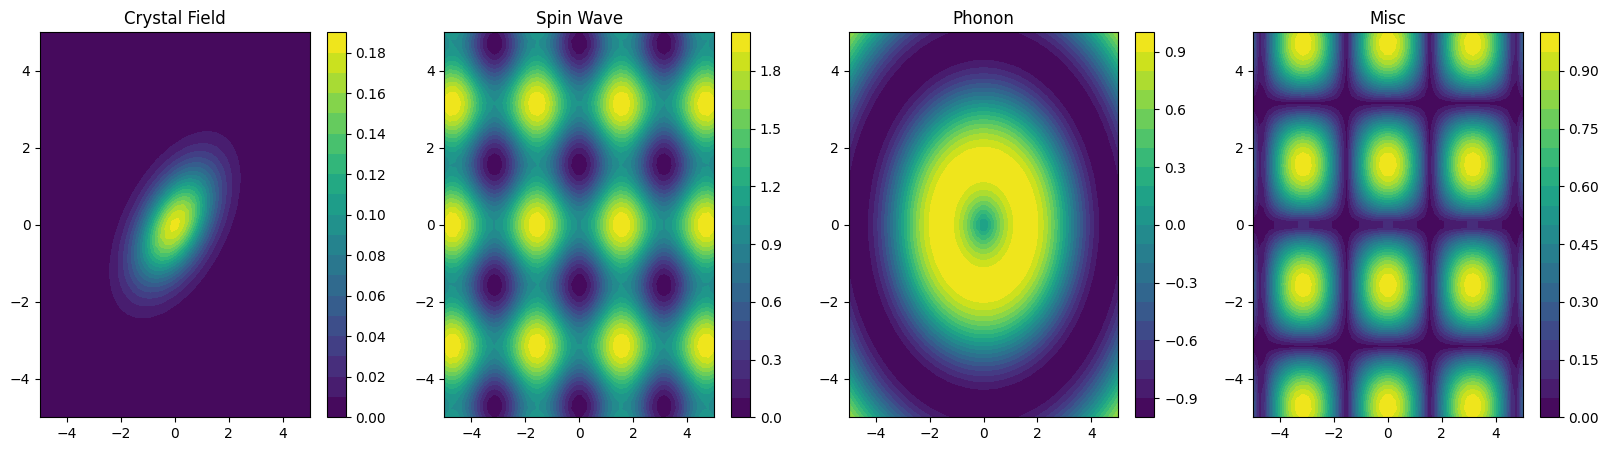

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def generate_field_data(type, grid_size, params):
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    if type == "crystal_field":
        mean = params['mean']
        cov = params['cov']
        rv = multivariate_normal(mean, cov)
        Z = rv.pdf(pos)
    elif type == "spin_wave":
        Z = np.sin(X) ** 2 + np.cos(Y) ** 2
    elif type == "phonon":
        Z = np.sin(np.sqrt(X**2 + Y**2))
    elif type == "misc":
        Z = np.abs(np.cos(X) * np.sin(Y))

    return X, Y, Z

# Paramètres de simulation pour les différents types
types = ["crystal_field", "spin_wave", "phonon", "misc"]
params = {
    "mean": np.array([0, 0]),
    "cov": np.array([[1, 0.5], [0.5, 1]])
}
grid_size = 50

# Génération des données et affichage
fig, axes = plt.subplots(1, len(types), figsize=(20, 5))
for ax, type in zip(axes, types):
    X, Y, Z = generate_field_data(type, grid_size, params)
    c = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.set_title(type.replace('_', ' ').title())
    fig.colorbar(c, ax=ax)
plt.show()

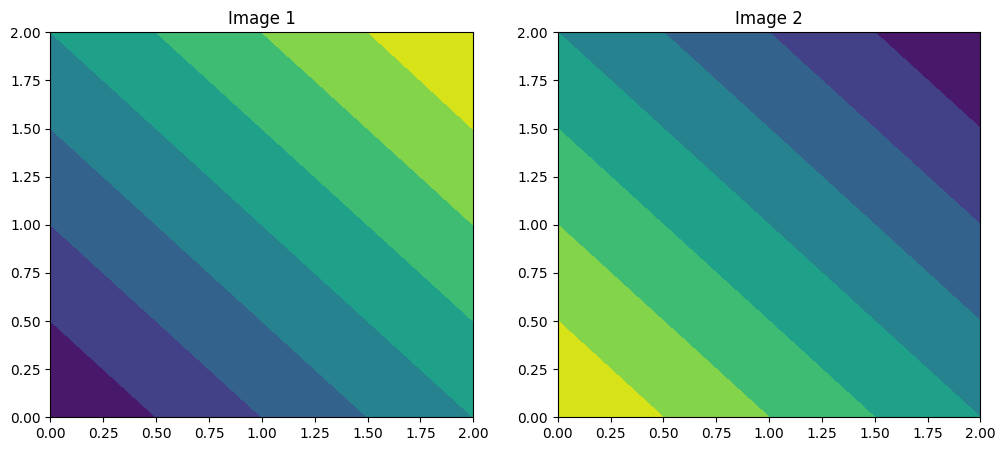

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Données des images fournies
data_image_1 = [[1, 2, 3],
                [2, 3, 4],
                [3, 4, 5]]

data_image_2 = [[5, 4, 3],
                [4, 3, 2],
                [3, 2, 1]]

# Création de la grille de coordonnées
x = np.arange(len(data_image_1))
y = np.arange(len(data_image_1[0]))
X, Y = np.meshgrid(x, y)

# Affichage des données de la première image
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].contourf(X, Y, data_image_1, cmap='viridis')
ax[0].set_title('Image 1')

# Affichage des données de la deuxième image
ax[1].contourf(X, Y, data_image_2, cmap='viridis')
ax[1].set_title('Image 2')

plt.show()

# Algorithme génétique

## Particle swarm

In [ ]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.7 MB/s eta 0:00:00


2024-05-02 13:12:34,067 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.159
2024-05-02 13:12:34,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.15915494290589802, best pos: [5.44723034e-06 4.80378942e-05]


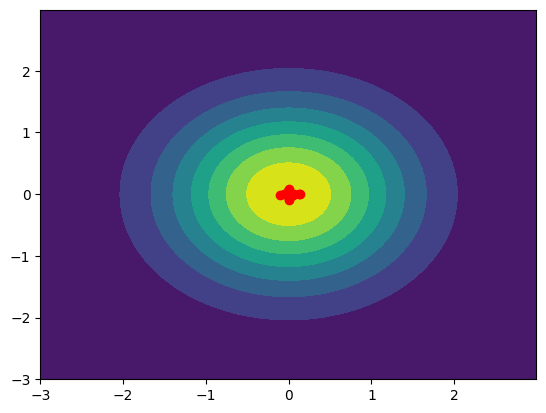

In [ ]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pyswarms as ps

# Définir la moyenne et la matrice de covariance de la distribution
mean = [0, 0]  # Exemple de moyenne pour une distribution 2D
cov = [[1, 0], [0, 1]]  # Exemple de matrice de covariance pour une distribution 2D

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    # Calculer la PDF pour chaque particule
    return -multivariate_normal(mean, cov).pdf(x)


# Nombre de particules dans l'essaim
n_particles = 100

# Hyperparamètres de l'optimiseur PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Créer une instance de l'optimiseur PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)

# Effectuer l'optimisation sur 100 itérations
cost, pos = optimizer.optimize(objective_function, iters=100)

# Extraire les positions des particules
particle_positions = optimizer.pos_history[-1]

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les positions des particules sur le plot
ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r')

# Afficher le plot
plt.show()

2024-05-02 13:15:23,891 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:15:24,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397124979319, best pos: [ 0.49998962 -0.1999266 ]


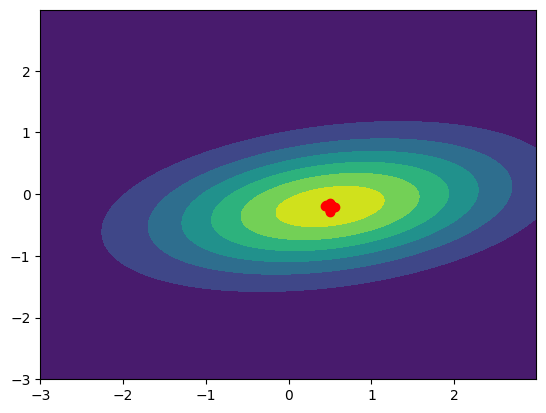

In [ ]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
import pyswarms as ps

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2])  # Moyenne pour une distribution 2D
cov = np.array([[2.0, 0.3], [0.3, 0.5]])  # Matrice de covariance pour une distribution 2D

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    # Calculer la PDF pour chaque particule
    return -multivariate_normal(mean, cov).pdf(x)

# Nombre de particules dans l'essaim
n_particles = 100

# Hyperparamètres de l'optimiseur PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Créer une instance de l'optimiseur PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)

# Effectuer l'optimisation sur 100 itérations
cost, pos = optimizer.optimize(objective_function, iters=100)

# Extraire les positions des particules
particle_positions = optimizer.pos_history[-1]

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les positions des particules sur le plot
ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r')

# Afficher le plot
plt.show()

2024-05-02 13:18:56,707 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.167
2024-05-02 13:18:56,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16681616407088629, best pos: [ 0.51370297 -0.20720403]


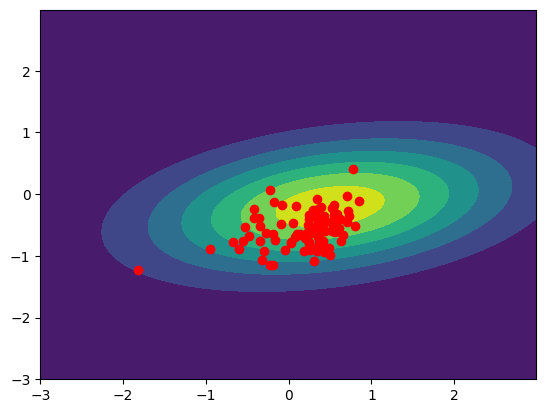

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pyswarms as ps

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2])  # Moyenne pour une distribution 2D
cov = np.array([[2.0, 0.3], [0.3, 0.5]])  # Matrice de covariance pour une distribution 2D

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    # Calculer la PDF pour chaque particule
    return -multivariate_normal(mean, cov).pdf(x)

# Nombre de particules dans l'essaim
n_particles = 100

# Hyperparamètres de l'optimiseur PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Créer une instance de l'optimiseur PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)

# Effectuer l'optimisation sur 100 itérations
cost, pos = optimizer.optimize(objective_function, iters=10)

# Extraire les positions des particules
particle_positions = optimizer.pos_history[-1]

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les positions des particules sur le plot avec un scatter plot
ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r')

# Afficher le plot
plt.show()

2024-05-02 13:41:50,231 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:50,745 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683971284668717, best pos: [ 0.50007273 -0.20003947]


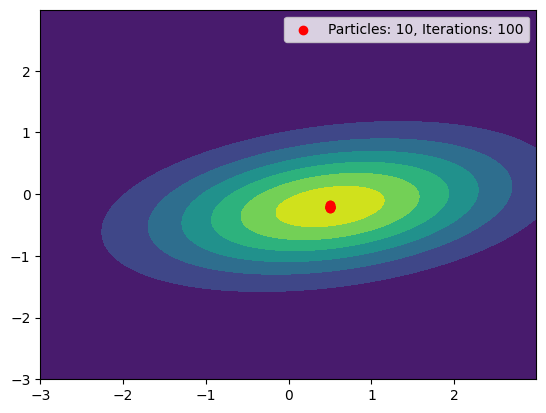

2024-05-02 13:41:51,434 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:52,005 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683970800649736, best pos: [ 0.49993782 -0.20018039]


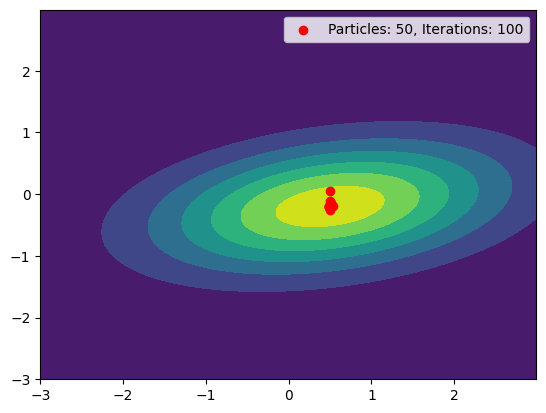

2024-05-02 13:41:52,372 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:52,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683971331007824, best pos: [ 0.49992889 -0.20000273]


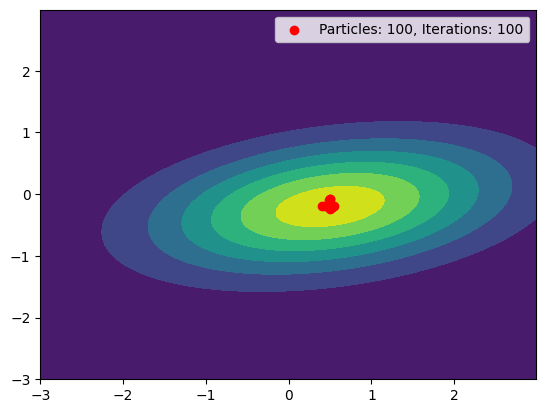

2024-05-02 13:41:53,127 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:53,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683971340787884, best pos: [ 0.49999658 -0.19997449]


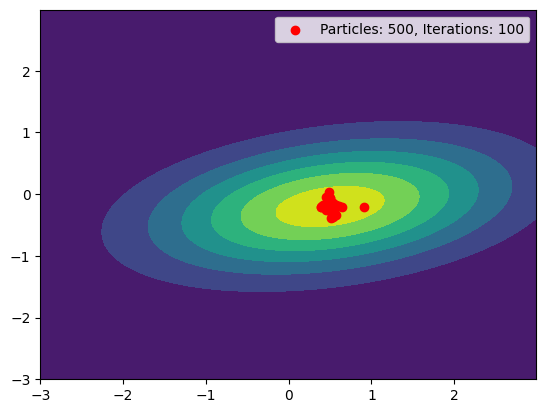

2024-05-02 13:41:53,964 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:54,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397135017476, best pos: [ 0.50000058 -0.19998695]


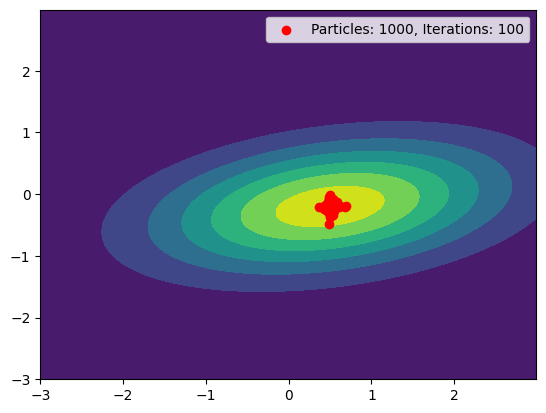

2024-05-02 13:41:54,808 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:55,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683971352025545, best pos: [ 0.49998981 -0.20000813]


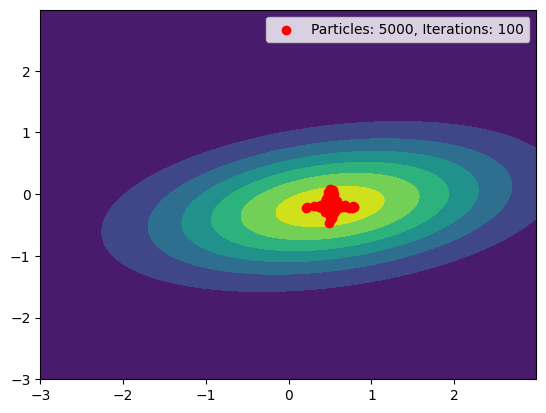

2024-05-02 13:41:56,091 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.167
2024-05-02 13:41:56,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668266705304153, best pos: [ 0.50962369 -0.19148017]


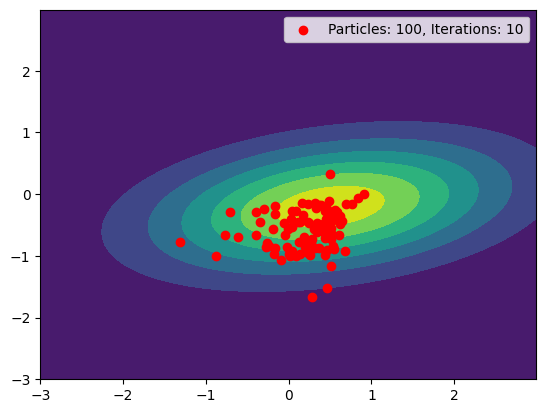

2024-05-02 13:41:56,647 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.167
2024-05-02 13:41:56,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668395645621224, best pos: [ 0.5013142  -0.19915509]


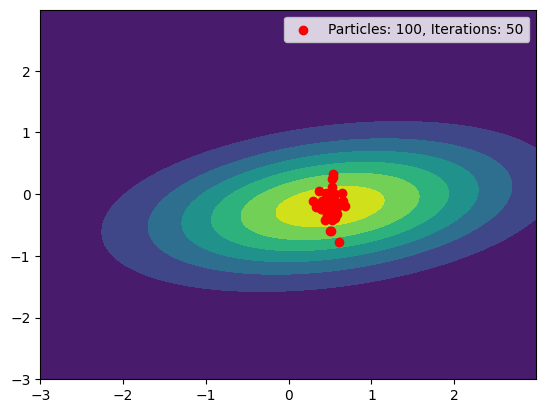

2024-05-02 13:41:57,336 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-02 13:41:57,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.16683971020370394, best pos: [ 0.49993281 -0.20014096]


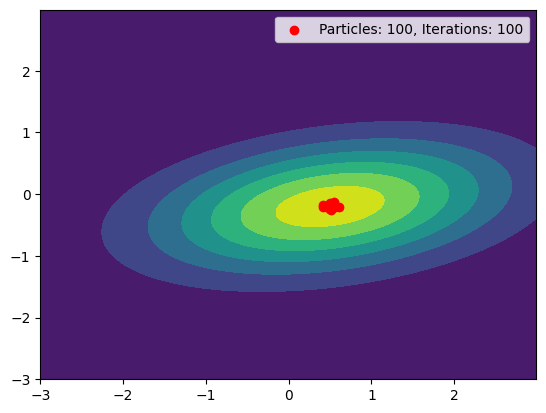

2024-05-02 13:41:58,170 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=-0.167
2024-05-02 13:41:59,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397135325737, best pos: [ 0.50000001 -0.2       ]


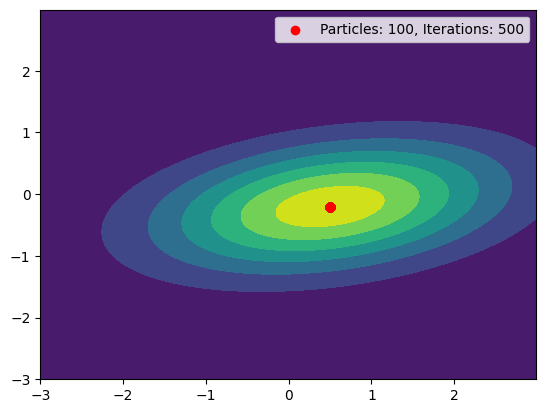

2024-05-02 13:42:00,428 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-0.167
2024-05-02 13:42:04,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397135325737, best pos: [ 0.50000001 -0.2       ]


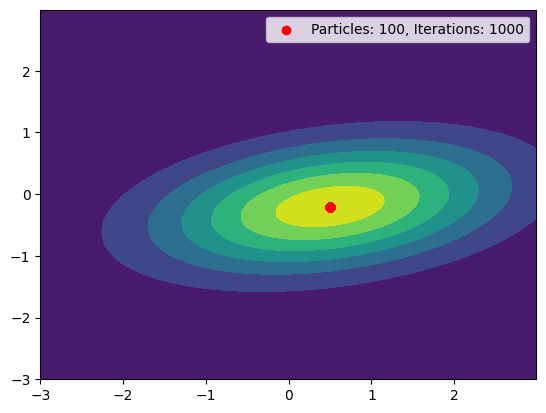

2024-05-02 13:42:04,621 - pyswarms.single.global_best - INFO - Optimize for 5000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|5000/5000, best_cost=-0.167
2024-05-02 13:42:23,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397135325737, best pos: [ 0.50000002 -0.2       ]


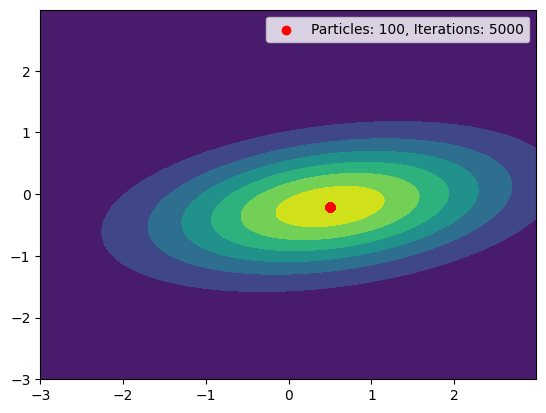

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pyswarms as ps

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2])
cov = np.array([[2.0, 0.3], [0.3, 0.5]])

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    return -multivariate_normal(mean, cov).pdf(x)

# Fonction pour exécuter l'optimisation PSO et générer un scatter plot
def run_pso_and_plot(n_particles, iters):
    # Hyperparamètres de l'optimiseur PSO
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

    # Créer une instance de l'optimiseur PSO
    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)

    # Effectuer l'optimisation
    cost, pos = optimizer.optimize(objective_function, iters=iters)

    # Extraire les positions des particules
    particle_positions = optimizer.pos_history[-1]

    # Créer un plot de contour pour la distribution normale multivariée
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    fig, ax = plt.subplots()
    ax.contourf(x, y, rv.pdf(pos))

    # Ajouter les positions des particules sur le plot avec un scatter plot
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r', label=f'Particles: {n_particles}, Iterations: {iters}')

    # Ajouter une légende
    ax.legend()

    # Afficher le plot
    plt.show()

# Liste des nombres de particules et d'itérations à tester
n_particles_list = [10, 50, 100, 500, 1000, 5000]
iterations_list = [10, 50, 100, 500, 1000, 5000]

# Exécuter les cas avec différentes particules
for n_particles in n_particles_list:
    run_pso_and_plot(n_particles, iters=100)

# Exécuter les cas avec différentes itérations
for iters in iterations_list:
    run_pso_and_plot(n_particles=100, iters=iters)

## Differential evolution

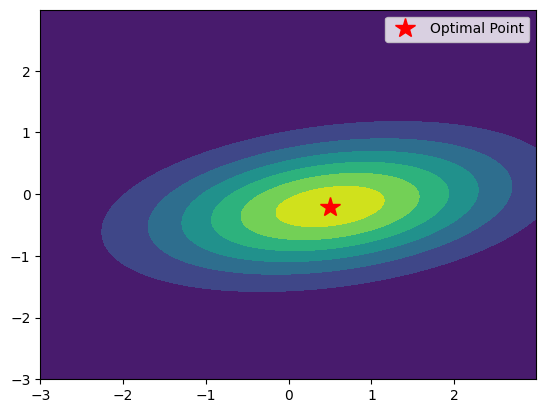

In [ ]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2], dtype=np.float64)
cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    return -multivariate_normal(mean, cov).pdf(x)

# Définir les bornes pour chaque variable
bounds = [(-3, 3), (-3, 3)]

# Effectuer l'optimisation différentielle
result = differential_evolution(objective_function, bounds)

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter le point optimal sur le plot
ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')

# Ajouter une légende
ax.legend()

# Afficher le plot
plt.show()

differential_evolution step 1: f(x)= -0.159065
differential_evolution step 2: f(x)= -0.163041
differential_evolution step 3: f(x)= -0.164845
differential_evolution step 4: f(x)= -0.165819
differential_evolution step 5: f(x)= -0.166693
differential_evolution step 6: f(x)= -0.166693
differential_evolution step 7: f(x)= -0.166715
differential_evolution step 8: f(x)= -0.16681
Polishing solution with 'L-BFGS-B'


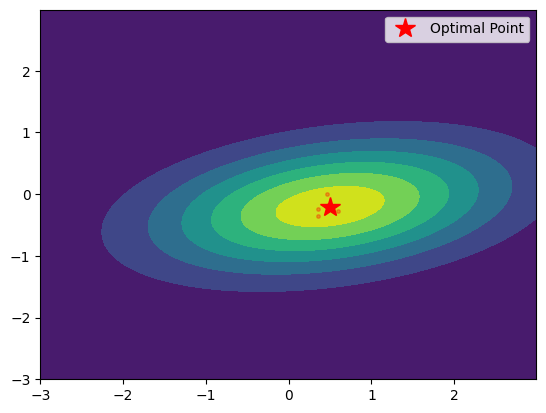

In [ ]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2], dtype=np.float64)
cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    return -multivariate_normal(mean, cov).pdf(x)

# Définir les bornes pour chaque variable
bounds = [(-3, 3), (-3, 3)]

# Préparer une liste pour enregistrer les positions des points à chaque itération
history = []

# Fonction de rappel pour enregistrer les positions des points
def callback(xk, convergence):
    history.append(xk)

# Effectuer l'optimisation différentielle
result = differential_evolution(objective_function, bounds, callback=callback, maxiter=10, disp=True)

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les positions des points à chaque itération sur le plot
for i, point in enumerate(history):
    ax.plot(point[0], point[1], 'r.', markersize=5, alpha=0.3)  # alpha pour la transparence

# Ajouter le point optimal sur le plot
ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')

# Ajouter une légende
ax.legend()

# Afficher le plot
plt.show()

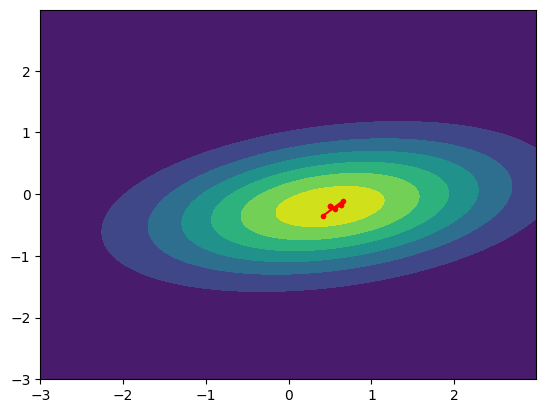

In [ ]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Définir la moyenne et la matrice de covariance de la distribution
mean = np.array([0.5, -0.2], dtype=np.float64)
cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)

# La fonction objectif à minimiser sera l'opposé de la PDF de la distribution normale multivariée
def objective_function(x):
    return -multivariate_normal(mean, cov).pdf(x)

# Définir les bornes pour chaque variable
bounds = [(-3, 3), (-3, 3)]

# Préparer une liste pour enregistrer la meilleure solution à chaque itération
best_solutions = []

# Fonction de rappel pour enregistrer la meilleure solution
def callback(xk, convergence):
    best_solutions.append(xk)

# Effectuer l'optimisation différentielle
result = differential_evolution(objective_function, bounds, callback=callback)

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les meilleures solutions à chaque itération sur le plot
best_solutions = np.array(best_solutions)
ax.plot(best_solutions[:, 0], best_solutions[:, 1], 'r.-')  # Points rouges avec des lignes

# Afficher le plot
plt.show()

## Comparaison

In [ ]:
import numpy as np
np.int= int
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import differential_evolution
import pyswarms as ps
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller
from dragonfly import maximise_function
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF
import time


# Définition de la fonction objectif
def objective_function(x):
    x = np.array(x, dtype=np.float64).flatten()
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

def objective_function2(x):
    mean = np.array([0.5, -0.2])
    cov = np.array([[2.0, 0.3], [0.3, 0.5]])
    rv = multivariate_normal(mean, cov)
    return -rv.pdf(x)

# Métriques de performance
performance_metrics = {
    'dragonfly': {'time': None, 'result': None},
    'pso': {'time': None, 'result': None},
    'de': {'time': None, 'result': None}
}

# Exécution de l'optimisation bayésienne avec Dragonfly
start_time = time.time()
class ScikitLearnGaussianProcessRegressor:
    def __init__(self, kernel, n_restarts_optimizer=0):
        # Initialisation du GPR avec le kernel spécifié et le nombre de redémarrages
        self.gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, y):
        # Méthode pour entraîner le modèle
        self.gpr.fit(X, y)

    def predict(self, X, return_std=False):
        # Méthode pour réaliser des prédictions
        return self.gpr.predict(X, return_std=return_std)


# Configuration du domaine pour les variables
domain_bounds = [{'name': 'var_1', 'type': 'float', 'min': -1, 'max': 1},
                 {'name': 'var_2', 'type': 'float', 'min': -1, 'max': 1}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Adapter la classe pour l'optimisation
class ModelAdapter:
    def __init__(self, model):
        self.model = model

    def evaluate(self, x):
        x_reshaped = np.array(x, dtype=np.float64).reshape(1, -1)
        return self.model.predict(x_reshaped, return_std=False)[0]

# Initialisation de la classe avec le kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
ariane_gpr = ScikitLearnGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# Exemple de données pour l'entraînement
X_sample = np.random.rand(10, 2).astype(np.float64)
y_sample = np.array([objective_function(x) for x in X_sample], dtype=np.float64)

# Entraînement du modèle
ariane_gpr.fit(X_sample, y_sample)

# Création de l'instance de l'adaptateur et configuration du CPFunctionCaller
adapted_model = ModelAdapter(ariane_gpr)
func_caller = CPFunctionCaller(adapted_model.evaluate, domain_obj)

# Exécution de l'optimisation Bayésienne
opt_val, opt_pt, history = maximise_function(func_caller.func, func_caller.domain, max_capital=100)
performance_metrics['dragonfly']['time'] = time.time() - start_time
performance_metrics['dragonfly']['result'] = history.curr_opt_vals[-1]


domain_bounds = [(-1, 1), (-1, 1)]
# Exécution de Particle Swarm Optimization (PSO)
start_time = time.time()
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(objective_function2, iters=100)
performance_metrics['pso']['time'] = time.time() - start_time
performance_metrics['pso']['result'] = -cost  # PSO minimizes the function, so take negative for maximization

# Exécution de Differential Evolution (DE)
start_time = time.time()
result = differential_evolution(objective_function2, domain_bounds, maxiter=100)
performance_metrics['de']['time'] = time.time() - start_time
performance_metrics['de']['result'] = -result.fun  # DE minimizes the function, so take negative for maximization

# Affichage des métriques de performance
for algo, metrics in performance_metrics.items():
    print(f"{algo} - Time: {metrics['time']:.4f} seconds, Result: {metrics['result']}")

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 100.0 (return_value)
Capital spent on initialisation: 8.0000(0.0800).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.110):: curr_max=0.16861, acqs=[ei:1, ucb:1, ttei:1, add_ucb:0], 
#026 (024, 0.240):: curr_max=0.16879, acqs=[ei:5, ucb:3, ttei:7, add_ucb:1], 
#039 (037, 0.370):: curr_max=0.16879, acqs=[ei:7, ucb:4, ttei:15, add_ucb:3], 
#052 (050, 0.500):: curr_max=0.16879, acqs=[ei:9, ucb:6, ttei:23, add_ucb:4], 
#065 (063, 0.630):: curr_max=0.16879, acqs=[ei:10, ucb:6, ttei:30, add_ucb:9], 
#078 (076, 0.760):: curr_max=0.16879, acqs=[ei:13, ucb:8, ttei:35, add_ucb:12], 
#091 (089, 0.890):: curr_max=0.16879, acqs=[ei:17, ucb:11, ttei:39, add_ucb:14], 
#102 (101, 1.010):: curr_max=0.16879, acqs=[ei:19, ucb:12, ttei:48, add_ucb:14], 


2024-05-08 09:37:15,720 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.167
2024-05-08 09:37:16,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1668397133554548, best pos: [ 0.50001086 -0.20002902]


dragonfly - Time: 372.5033 seconds, Result: 0.1687917321201713
pso - Time: 0.3827 seconds, Result: 0.1668397133554548
de - Time: 0.1291 seconds, Result: 0.16683971350846238


# Complex function

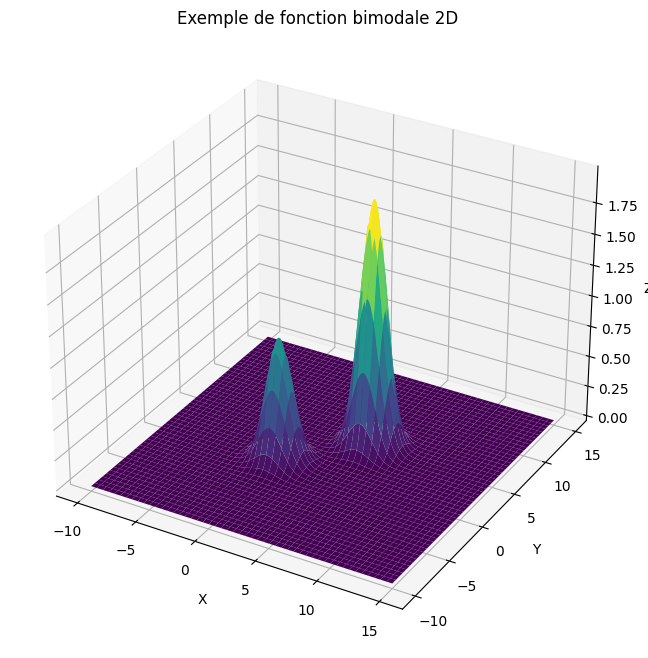

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bimodal_function_2d(x, y, mu1=[0, 0], sigma1=[1, 1], mu2=[5, 5], sigma2=[1, 1]):
    """
    Fonction bimodale 2D combinant deux gaussiennes 2D.

    Paramètres :
    - x, y : grilles de points où la fonction est évaluée.
    - mu1, mu2 : centres des gaussiennes (listes de deux éléments).
    - sigma1, sigma2 : écarts-types des gaussiennes (listes de deux éléments).
    """
    # Première gaussienne 2D
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))

    # Deuxième gaussienne 2D
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))

    # Combinaison des deux gaussiennes
    return gauss1 + 2*gauss2

# Création des grilles de points x et y
x = np.linspace(-10, 15, 400)
y = np.linspace(-10, 15, 400)
X, Y = np.meshgrid(x, y)

# Calcul de la fonction bimodale 2D
Z = bimodal_function_2d(X, Y)

# Affichage en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_title('Exemple de fonction bimodale 2D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

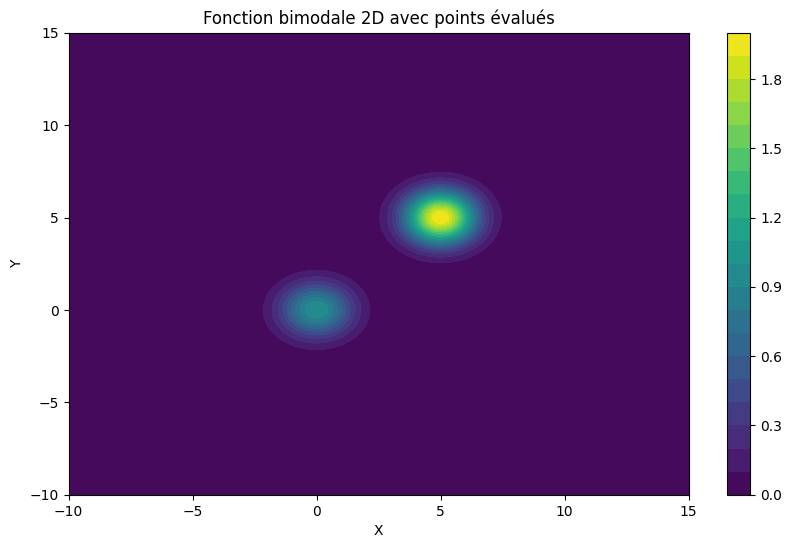

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bimodal_function_2d(x, y, mu1=[0, 0], sigma1=[1, 1], mu2=[5, 5], sigma2=[1, 1]):

    # Première gaussienne 2D
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))

    # Deuxième gaussienne 2D
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))

    # Combinaison des deux gaussiennes
    return gauss1 + 2*gauss2


# Calcul de la fonction bimodale 2D
Z = bimodal_function_2d(X, Y)

# Affichage du graphique de contour avec les points évalués
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour)
plt.title('Fonction bimodale 2D avec points évalués')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Animation

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller
from dragonfly import maximise_function
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import webbrowser
import os
import subprocess


# Define the objective function to be maximised
def objective_function(x):
    x = np.atleast_2d(x)  # Ensure x is 2D
    mean = np.array([0.5, -0.2], dtype=np.float64)
    cov = np.array([[2.0, 0.3], [0.3, 0.5]], dtype=np.float64)
    rv = multivariate_normal(mean, cov)
    return rv.pdf(x)

# Define the domain of the function
domain_bounds = [{'name': 'var_1', 'type': 'float', 'min': -3, 'max': 3},
                 {'name': 'var_2', 'type': 'float', 'min': -3, 'max': 3}]
domain_bounds_list = np.array([[d['min'], d['max']] for d in domain_bounds], dtype=np.float64)
domain_obj = domains.EuclideanDomain(domain_bounds_list)

# Create a function caller for the objective function
func_caller = CPFunctionCaller(objective_function, domain_obj)

# Set the maximum capital for the optimization (e.g., number of iterations)
max_capital = 100

# Perform the optimization using Dragonfly
opt_val, opt_pt, history = maximise_function(func_caller.func, func_caller.domain, max_capital=max_capital)

# Extract the evaluated points for animation
evaluated_points = [[float(pt[0]), float(pt[1])] for pt in history.query_points]

# Generate the meshgrid for the contour plot
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate the objective function at each point in the 2D grid
Z = np.array([objective_function(point) for point in points])
Z = Z.reshape(X.shape)

# Create the contour plot
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')

# Initialize the points plot for animation
points_plot, = ax.plot([], [], 'ro', markersize=4)

def init():
    points_plot.set_data([], [])
    return (points_plot,)  # Return a tuple

def update(frame):
    x_data = [point[0] for point in evaluated_points[:frame+1]]
    y_data = [point[1] for point in evaluated_points[:frame+1]]
    points_plot.set_data(x_data, y_data)
    return (points_plot,)  # Return a tuple

# Nom du fichier HTML spécifié par l'utilisateur
filename = 'my_animation.html'
# Chemin complet dans Google Drive
path = f'/content/drive/My Drive/my_animation.html'


# Création de l'objet d'animation
ani = FuncAnimation(fig, update, frames=len(evaluated_points), init_func=init, blit=True)

# Sauvegarde de l'animation en tant que code HTML
html_code = ani.to_html5_video()

# Écriture du code HTML dans le fichier sur Google Drive
with open(path, "w") as html_file:
    html_file.write(html_code)

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 100.0 (return_value)
Capital spent on initialisation: 8.0000(0.0800).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.110):: curr_max=-0.00000, acqs=[ei:1, ucb:1, ttei:1, add_ucb:0], 
#026 (024, 0.240):: curr_max=-0.00000, acqs=[ei:3, ucb:5, ttei:4, add_ucb:4], 
#039 (037, 0.370):: curr_max=-0.00000, acqs=[ei:6, ucb:8, ttei:6, add_ucb:9], 
#052 (050, 0.500):: curr_max=-0.00000, acqs=[ei:11, ucb:13, ttei:7, add_ucb:11], 
#065 (063, 0.630):: curr_max=-0.00000, acqs=[ei:15, ucb:17, ttei:10, add_ucb:13], 
#078 (076, 0.760):: curr_max=-0.00000, acqs=[ei:19, ucb:21, ttei:12, add_ucb:16], 
#091 (089, 0.890):: curr_max=-0.00000, acqs=[ei:20, ucb:25, ttei:15, add_ucb:21], 
#102 (101, 1.010):: curr_max=-0.00000, acqs=[ei:24, ucb:29, ttei:17, add_ucb:23], 
The maximum value of the PDF is -8.045282069138929e-14 at the

2024-05-20 10:41:41,697 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 10:41:41,700 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpq8tkkkqv/temp.m4v


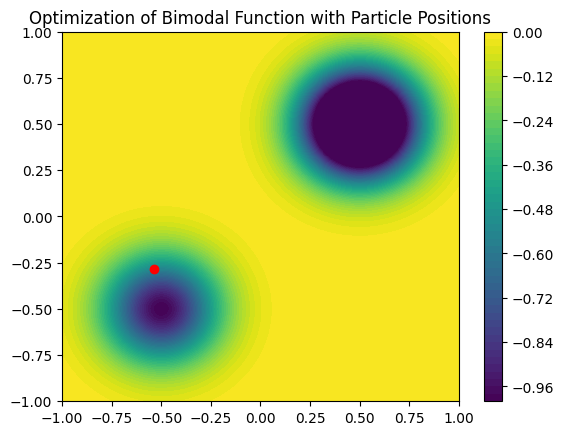

In [ ]:
import numpy as np
np.int=int
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dragonfly import maximise_function
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import EuclideanFunctionCaller

# Définition de la fonction bimodale pour l'optimisation
def bimodal_function_2d_for_optimization(X):
    x = X[0]
    y = X[1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    return np.clip(result, -1, 1)  # Contraindre les valeurs entre -1 et 1

# Définir l'espace de recherche
domain_bounds = [[-1, 1], [-1, 1]]
domain = domains.EuclideanDomain(domain_bounds)

# Créer un appelant de fonction
func_caller = EuclideanFunctionCaller(None, domain)

# Exécuter l'optimisation bayésienne
opt_val, opt_pt, history = maximise_function(bimodal_function_2d_for_optimization, domain, max_capital=100)

# Affichage des résultats
print(f"The maximum value of the PDF is {opt_val} at the point {opt_pt}")

# Fonction pour tracer la fonction bimodale
def plot_bimodal_function(ax):
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = bimodal_function_2d_for_optimization([X.ravel(), Y.ravel()]).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    return contour

# Création de la figure et des axes une seule fois
fig, ax = plt.subplots()
# Tracer la fonction bimodale initiale
contour = plot_bimodal_function(ax)
plt.colorbar(contour)
ax.set_title('Optimization of Bimodal Function with Particle Positions')

# Définir les limites du carré coloré
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

# Animation
def update(frame):
    global contour
    # Supprimer l'ancien tracé de contour
    for c in contour.collections:
        c.remove()
    # Redessiner la fonction bimodale
    contour = plot_bimodal_function(ax)
    # Mettre à jour les positions des particules
    particle_positions = np.array(history.query_points[frame])
    if particle_positions.ndim == 1:
        ax.scatter(particle_positions[0], particle_positions[1], color='r')
    else:
        ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r')

# Créer l'objet d'animation
ani = FuncAnimation(fig, update, frames=len(history.query_points), repeat=False)

# Sauvegarde de l'animation en HTML
html_code = ani.to_html5_video()
path = '/content/drive/My Drive/my_animation13.html'
with open(path, "w") as html_file:
    html_file.write(html_code)

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 200.0 (return_value)
Capital spent on initialisation: 10.0000(0.0500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>
#013 (011, 0.055):: curr_max=0.07938, acqs=[ei:0, ucb:1, ttei:0, add_ucb:0], 
#026 (024, 0.120):: curr_max=0.23765, acqs=[ei:4, ucb:6, ttei:2, add_ucb:2], 
#039 (037, 0.185):: curr_max=0.23765, acqs=[ei:7, ucb:10, ttei:6, add_ucb:4], 
#052 (050, 0.250):: curr_max=0.23765, acqs=[ei:10, ucb:14, ttei:10, add_ucb:6], 
#065 (063, 0.315):: curr_max=0.23765, acqs=[ei:15, ucb:19, ttei:10, add_ucb:9], 
#078 (076, 0.380):: curr_max=0.23765, acqs=[ei:19, ucb:23, ttei:13, add_ucb:11], 
#091 (089, 0.445):: curr_max=0.23765, acqs=[ei:19, ucb:30, ttei:15, add_ucb:15], 
#104 (102, 0.510):: curr_max=0.23765, acqs=[ei:27, ucb:32, ttei:17, add_ucb:16], 
#117 (115, 0.575):: curr_max=0.23765, acqs=[ei:32, ucb:34, ttei:20, 

2024-05-20 11:03:51,038 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 11:03:51,041 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbttitgyh/temp.m4v


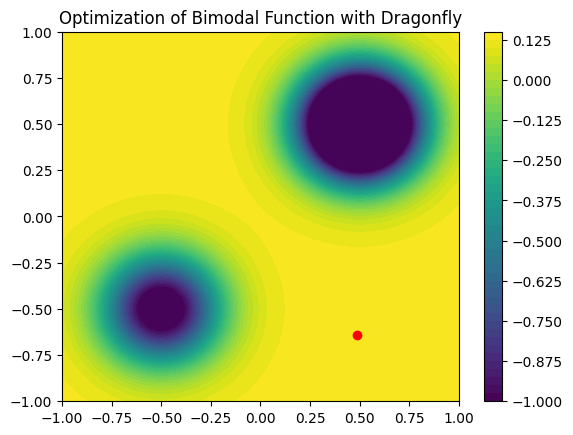

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dragonfly import maximise_function
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import EuclideanFunctionCaller

# Définition de la fonction bimodale pour l'optimisation
def bimodal_function_2d_for_optimization(X):
    x = X[0]
    y = X[1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    return np.clip(result, -1, 1)  # Contraindre les valeurs entre -1 et 1

# Définir l'espace de recherche
domain_bounds = [[-1, 1], [-1, 1]]
domain = domains.EuclideanDomain(domain_bounds)

# Créer un appelant de fonction
func_caller = EuclideanFunctionCaller(None, domain)

# Exécuter l'optimisation bayésienne
opt_val, opt_pt, history = maximise_function(bimodal_function_2d_for_optimization, domain, max_capital=200)

# Affichage des résultats
print(f"The maximum value of the PDF is {opt_val} at the point {opt_pt}")

# Fonction pour tracer la fonction bimodale
def plot_bimodal_function(ax):
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = bimodal_function_2d_for_optimization([X.ravel(), Y.ravel()]).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    return contour

# Création de la figure et des axes une seule fois
fig, ax = plt.subplots()
# Tracer la fonction bimodale initiale
contour = plot_bimodal_function(ax)
plt.colorbar(contour)
ax.set_title('Optimization of Bimodal Function with Dragonfly')

# Définir les limites du carré coloré
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

# Animation
def update(frame):
    global contour
    # Supprimer l'ancien tracé de contour
    for c in contour.collections:
        c.remove()
    # Redessiner la fonction bimodale
    contour = plot_bimodal_function(ax)
    # Mettre à jour les positions des particules
    particle_positions = np.array(history.query_points[frame])
    if particle_positions.ndim == 1:
        ax.scatter(particle_positions[0], particle_positions[1], color='r')
    else:
        ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r')

# Créer l'objet d'animation
ani = FuncAnimation(fig, update, frames=len(history.query_points), repeat=False)

# Sauvegarde de l'animation en HTML
html_code = ani.to_html5_video()
path = '/content/drive/My Drive/my_animation14.html'
with open(path, "w") as html_file:
    html_file.write(html_code)

2024-05-10 10:51:05,657 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2
2024-05-10 10:51:05,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.9999998486053703, best pos: [-0.49992535 -0.499978  ]


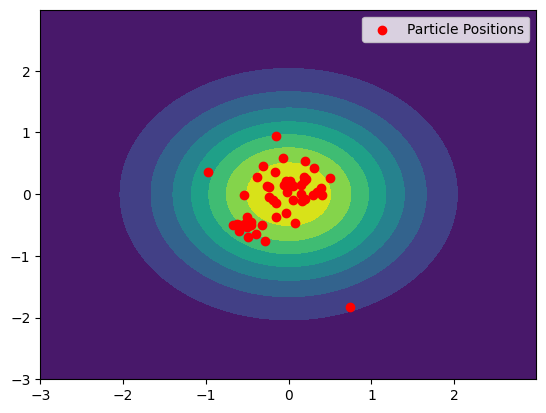

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pyswarms as ps

def bimodal_function_2d_for_optimization(X):
    # X est un tableau où chaque ligne représente les positions (x, y) d'une particule
    x = X[:, 0]
    y = X[:, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    return -(2*gauss1 + gauss2)  # Minimiser l'opposé pour une maximisation

n_particles = 100

# Hyperparamètres de l'optimiseur PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Créer une instance de l'optimiseur PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)

# Effectuer l'optimisation sur 100 itérations
cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=100)

# Extraire les positions des particules
particle_positions = optimizer.pos_history[-1]

# Créer un plot de contour pour la distribution normale multivariée
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
mean = [0, 0]  # Définir la moyenne de la distribution
cov = [[1, 0], [0, 1]]  # Définir la matrice de covariance de la distribution
rv = multivariate_normal(mean, cov)
fig, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# Ajouter les positions des particules sur le plot
ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r', label='Particle Positions')
ax.legend()

# Afficher le plot
plt.show()

2024-05-13 13:10:30,431 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=-2
2024-05-13 13:10:32,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.0000000071941333, best pos: [-0.5        -0.49999999]


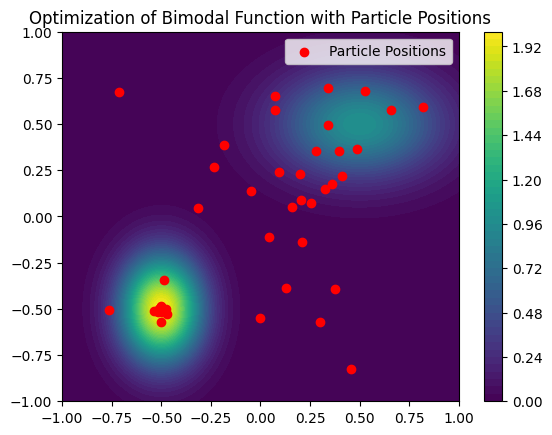

2024-05-13 13:11:44,239 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-13 13:11:44,243 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmyvwv7zi/temp.m4v


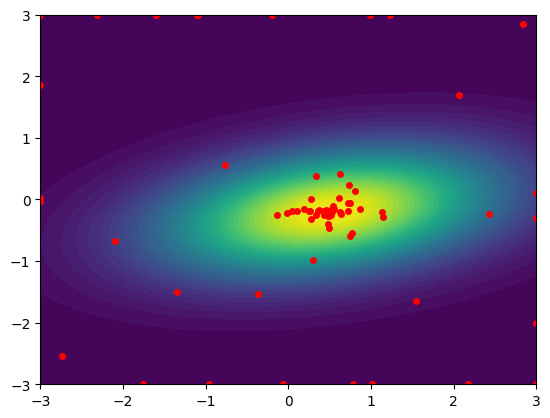

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps

def bimodal_function_2d_for_optimization(X):
    x = X[:, 0]
    y = X[:, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    return -(2*gauss1 + gauss2)  # Minimiser l'opposé pour une maximisation

def plot_bimodal_function():
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)

    fig, ax = plt.subplots()
    contour = ax.contourf(X, Y, -Z, levels=50, cmap='viridis')  # Utiliser -Z pour afficher la maximisation
    plt.colorbar(contour)
    return ax

n_particles = 500
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=2, options=options)
cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=500)

# Extraire les positions des particules
particle_positions = np.array(optimizer.pos_history[-1])

# Afficher la fonction bimodale et les positions des particules
ax = plot_bimodal_function()
ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='r', label='Particle Positions')
ax.legend()
plt.title('Optimization of Bimodal Function with Particle Positions')
plt.show()

evaluated_points = [[float(pt[0]), float(pt[1])] for pt in history.query_points]

# Generate the meshgrid for the contour plot
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate the objective function at each point in the 2D grid
Z = np.array([objective_function(point) for point in points])
Z = Z.reshape(X.shape)

# Create the contour plot
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')

# Initialize the points plot for animation
points_plot, = ax.plot([], [], 'ro', markersize=4)

def init():
    points_plot.set_data([], [])
    return (points_plot,)  # Return a tuple

def update(frame):
    x_data = [point[0] for point in evaluated_points[:frame+1]]
    y_data = [point[1] for point in evaluated_points[:frame+1]]
    points_plot.set_data(x_data, y_data)
    return (points_plot,)  # Return a tuple

# Nom du fichier HTML spécifié par l'utilisateur
filename = 'my_animation2.html'
# Chemin complet dans Google Drive
path = f'/content/drive/My Drive/my_animation2.html'


# Création de l'objet d'animation
ani = FuncAnimation(fig, update, frames=len(evaluated_points), init_func=init, blit=True)

# Sauvegarde de l'animation en tant que code HTML
html_code = ani.to_html5_video()

# Écriture du code HTML dans le fichier sur Google Drive
with open(path, "w") as html_file:
    html_file.write(html_code)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

def bimodal_function_2d_for_optimization(X):
    x, y = X
    mu1, mu2 = [-0.5, -0.5], [0.5, 0.5]
    sigma1, sigma2 = [0.2, 0.2], [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    return -(2*gauss1 + gauss2)

bounds = [(-3, 3), (-3, 3)]
result = differential_evolution(bimodal_function_2d_for_optimization, bounds)

# Réduire la résolution du maillage
x, y = np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([bimodal_function_2d_for_optimization([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, -Z, levels=20, cmap='viridis')  # Réduire le nombre de niveaux de contour
plt.colorbar(contour)
ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')
ax.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the bimodal function to be optimized with added noise
def bimodal_function_2d_for_optimization(X):
    x, y = X
    mu1, mu2 = [-0.5, -0.5], [0.5, 0.5]
    sigma1, sigma2 = [0.2, 0.2], [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    noise = np.random.normal(0, 0.1)  # Adding noise with mean 0 and standard deviation 0.1
    result += noise  # Adding noise to the result
    return np.clip(result, -1, 1)

# Set the bounds for the variables
bounds = [(-1, 1), (-1, 1)]

# Callback function to capture optimization history
history = []
def callback(xk, convergence):
    history.append(xk)

# Perform the differential evolution algorithm
result = differential_evolution(bimodal_function_2d_for_optimization, bounds, callback=callback)

# Generate data for contour plot
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([bimodal_function_2d_for_optimization([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Create the plot
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
# Plot all evaluated points
history = np.array(history)
ax.scatter(history[:, 0], history[:, 1], color='white', s=10, label='Evaluated Points')
ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')
ax.legend()

# Define the update function for the animation
def update(frame):
    global Z
    # Generate new noisy Z data for each frame
    Z = np.array([bimodal_function_2d_for_optimization([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    # Update the contour plot with the new noisy data
    ax.clear()
    contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(history[:, 0], history[:, 1], color='white', s=10, label='Evaluated Points')
    ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')
    ax.legend()
    return contour,

# Create the animation object
ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Convert the animation to HTML5 video and display it within the notebook
HTML(ani.to_html5_video())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the bimodal function to be optimized with added noise
def bimodal_function_2d_for_optimization(X):
    x, y = X
    mu1, mu2 = [-0.5, -0.5], [0.5, 0.5]
    sigma1, sigma2 = [0.2, 0.2], [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    noise = np.random.normal(0, 0.1)  # Adding noise with mean 0 and standard deviation 0.1
    result += noise  # Adding noise to the result
    return np.clip(result, -1, 1)

# Set the bounds for the variables
bounds = [(-1, 1), (-1, 1)]

# Callback function to capture optimization history
history = []
def callback(xk, convergence):
    history.append(xk)

# Perform the differential evolution algorithm
result = differential_evolution(bimodal_function_2d_for_optimization, bounds, callback=callback)

# Generate data for contour plot
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([bimodal_function_2d_for_optimization([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Create the plot
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
# Plot all evaluated points
history = np.array(history)
ax.scatter(history[:, 0], history[:, 1], color='white', s=10, label='Evaluated Points')
ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')
ax.legend()

# Define the update function for the animation
def update(frame):
    global Z
    # Generate new noisy Z data for each frame
    Z = np.array([bimodal_function_2d_for_optimization([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    # Update the contour plot with the new noisy data
    ax.clear()
    contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(history[:, 0], history[:, 1], color='white', s=10, label='Evaluated Points')
    ax.plot(result.x[0], result.x[1], 'r*', markersize=15, label='Optimal Point')
    ax.legend()
    return contour,

ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Sauvegarde de l'animation en HTML
html_code = ani.to_html5_video()
path = '/content/drive/My Drive/my_animation2.html'
with open(path, "w") as html_file:
    html_file.write(html_code)

### Noise

#### Gaussian

2024-05-15 12:17:42,331 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7964223091125092, 'c2': 0.437706299432407, 'w': 0.8289728088113786}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-15 12:17:42,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.30360411 0.45191929]
2024-05-15 12:17:42,761 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9236258693920628, 'c2': 0.349425478714389, 'w': 0.59219085364635}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-15 12:17:43,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.45142667 0.63315291]
2024-05-15 12:17:43,216 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6487673032722362, 'c2': 0.12268519092697729, 'w': 0.5363281472900566}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-15 12:17:43

Meilleurs hyperparamètres: [0.7964223091125092, 0.437706299432407, 0.8289728088113786]


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-15 12:18:10,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.64459815 0.43312682]
2024-05-15 12:18:14,544 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-15 12:18:14,553 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp12pnmf9z/temp.m4v


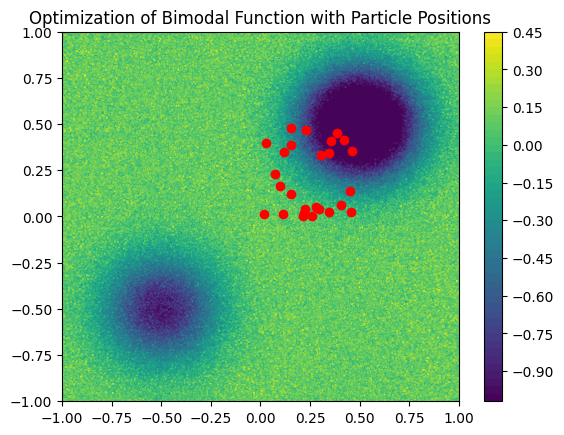

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Définition de la fonction bimodale pour l'optimisation
def bimodal_function_2d_for_optimization(X):
    x = X[:, 0]
    y = X[:, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    noise_gaussian = np.random.normal(0, 0.1, X.shape[0])  # Ajout de bruit avec une moyenne de 0 et un écart-type de 0.1
    result += noise   # Minimiser l'opposé pour une maximisation
    return np.clip(result, -1, 1)  # Contraindre les valeurs entre -1 et 1

space = [Real(0.5, 1.0, name='c1'),
         Real(0.1, 0.5, name='c2'),
         Real(0.4, 0.9, name='w')]

# Définir la fonction objectif pour l'optimisation bayésienne
@use_named_args(space)
def objective(**params):
    # Créer une instance de l'optimiseur PSO avec les hyperparamètres proposés
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=params)
    # Exécuter l'optimisation PSO sur la fonction bimodale
    cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=100)
    # La fonction objectif est le coût retourné par l'optimiseur PSO
    return cost

# Exécuter l'optimisation bayésienne
res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# Les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres: %s" % res_gp.x)

# Utiliser les meilleurs hyperparamètres pour exécuter l'optimiseur PSO
optimized_params = {'c1': res_gp.x[0], 'c2': res_gp.x[1], 'w': res_gp.x[2]}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=optimized_params)
cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=100)

# Fonction pour tracer la fonction bimodale
def plot_bimodal_function(ax):
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    return contour

# Création de la figure et des axes une seule fois
fig, ax = plt.subplots()
# Tracer la fonction bimodale initiale
contour = plot_bimodal_function(ax)
plt.colorbar(contour)
ax.set_title('Optimization of Bimodal Function with Particle Positions')

# Définir les limites du carré coloré
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

# Animation
def update(frame):
    global contour
    # Supprimer l'ancien tracé de contour
    for c in contour.collections:
        c.remove()
    # Redessiner la fonction bimodale
    contour = plot_bimodal_function(ax)
    # Filtrer et mettre à jour les positions des particules à l'intérieur du carré
    particle_positions = np.array(optimizer.pos_history[frame])
    inside_particles = particle_positions[
        (particle_positions[:, 0] >= x_min) & (particle_positions[:, 0] <= x_max) &
        (particle_positions[:, 1] >= y_min) & (particle_positions[:, 1] <= y_max)
    ]
    ax.scatter(inside_particles[:, 0], inside_particles[:, 1], color='r')

# Créer l'objet d'animation
ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Sauvegarde de l'animation en HTML
html_code = ani.to_html5_video()
path = '/content/drive/My Drive/my_animation2.html'
with open(path, "w") as html_file:
    html_file.write(html_code)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Définition de la fonction bimodale pour l'optimisation
def bimodal_function_2d_for_optimization(X):
    x = X[:, 0]
    y = X[:, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2*gauss2)
    noise_gaussian = np.random.normal(0, 0.1, X.shape[0])  # Ajout de bruit avec une moyenne de 0 et un écart-type de 0.1
    result += noise   # Minimiser l'opposé pour une maximisation
    return np.clip(result, -1, 1)  # Contraindre les valeurs entre -1 et 1

space = [Real(0.5, 1.0, name='c1'),
         Real(0.1, 0.5, name='c2'),
         Real(0.4, 0.9, name='w')]

# Définir la fonction objectif pour l'optimisation bayésienne
@use_named_args(space)
def objective(**params):
    # Créer une instance de l'optimiseur PSO avec les hyperparamètres proposés
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=params)
    # Exécuter l'optimisation PSO sur la fonction bimodale
    cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=100)
    # La fonction objectif est le coût retourné par l'optimiseur PSO
    return cost

# Exécuter l'optimisation bayésienne
res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# Les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres: %s" % res_gp.x)

# Utiliser les meilleurs hyperparamètres pour exécuter l'optimiseur PSO
optimized_params = {'c1': res_gp.x[0], 'c2': res_gp.x[1], 'w': res_gp.x[2]}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=optimized_params)
cost, pos = optimizer.optimize(bimodal_function_2d_for_optimization, iters=100)

# Fonction pour tracer la fonction bimodale
def plot_bimodal_function(ax):
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    return contour

# Création de la figure et des axes une seule fois
fig, ax = plt.subplots()
# Tracer la fonction bimodale initiale
contour = plot_bimodal_function(ax)
plt.colorbar(contour)
ax.set_title('Optimization of Bimodal Function with Particle Positions')

# Définir les limites du carré coloré
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

# Animation
def update(frame):
    global contour
    # Supprimer l'ancien tracé de contour
    for c in contour.collections:
        c.remove()
    # Redessiner la fonction bimodale
    contour = plot_bimodal_function(ax)
    # Filtrer et mettre à jour les positions des particules à l'intérieur du carré
    particle_positions = np.array(optimizer.pos_history[frame])
    inside_particles = particle_positions[
        (particle_positions[:, 0] >= x_min) & (particle_positions[:, 0] <= x_max) &
        (particle_positions[:, 1] >= y_min) & (particle_positions[:, 1] <= y_max)
    ]
    ax.scatter(inside_particles[:, 0], inside_particles[:, 1], color='r')

# Créer l'objet d'animation
ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Sauvegarde de l'animation en HTML
html_code = ani.to_html5_video()
path = '/content/drive/My Drive/my_animation2.html'
with open(path, "w") as html_file:
    html_file.write(html_code)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)  # Contraindre x à l'intervalle [-1, 1]
    y = np.clip(X[:, 1], -1, 1)  # Contraindre y à l'intervalle [-1, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(lambda X: bimodal_function_2d_for_optimization(X, noise_type="gaussian"), iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="gaussian").reshape(X.shape)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)

def animate(frame):
    ax.clear()
    ax.set_title(f"Noise Type: Gaussian, Frame {frame + 1}")
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="gaussian").reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)  # Assurez-vous que les particules restent dans les limites
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation8.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

2024-05-20 12:29:00,046 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 12:29:00,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.68536817 0.38542036]
2024-05-20 12:29:09,129 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 12:29:09,145 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpb_ec_v8t/temp.m4v


#### Uniform

2024-05-20 08:29:00,469 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 08:29:00,798 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.53856955 0.29431296]
2024-05-20 08:29:05,406 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 08:29:05,414 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpy5wi4_ld/temp.m4v


L'animation a été sauvegardée au format HTML5. Vous pouvez la retrouver ici : /content/drive/My Drive/my_animation5.html


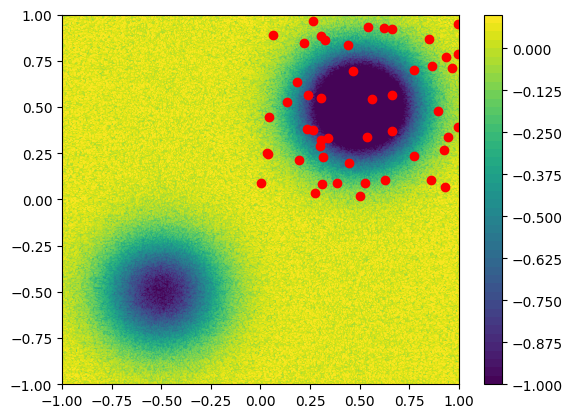

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

# Définition des différents types de bruit
def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

# Fonction bimodale pour l'optimisation avec bruit configurable
def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = X[:, 0]
    y = X[:, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

# Configuration de l'optimisation et de l'animation
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(lambda X: bimodal_function_2d_for_optimization(X, noise_type="uniform"), iters=100)

# Préparation de la figure et de l'animation
fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="uniform").reshape(X.shape)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)

def animate(frame):
    ax.clear()
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="uniform").reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation5.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

print(f"L'animation a été sauvegardée au format HTML5. Vous pouvez la retrouver ici : {html_file_path}")

2024-05-20 08:37:41,371 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 08:37:42,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.70416434 0.50078425]
2024-05-20 08:37:45,534 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 08:37:45,542 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9m4h0r3w/temp.m4v


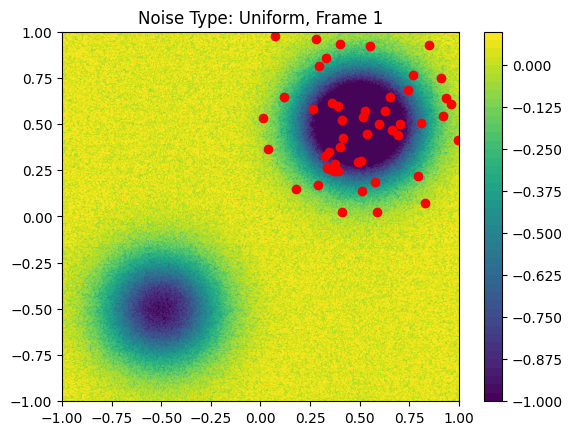

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)  # Contraindre x à l'intervalle [-1, 1]
    y = np.clip(X[:, 1], -1, 1)  # Contraindre y à l'intervalle [-1, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(lambda X: bimodal_function_2d_for_optimization(X, noise_type="uniform"), iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="uniform").reshape(X.shape)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)

def animate(frame):
    ax.clear()
    ax.set_title(f"Noise Type: Uniform, Frame {frame + 1}")
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="uniform").reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)  # Assurez-vous que les particules restent dans les limites
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation6.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

#### Sinusoidal

2024-05-20 09:35:42,597 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 09:35:42,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.61788946 0.49946437]
2024-05-20 09:35:43,117 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 09:35:43,120 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6wj1vn0a/temp.m4v


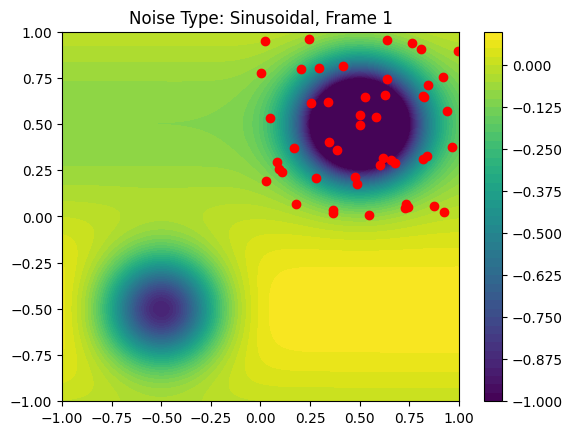

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)  # Contraindre x à l'intervalle [-1, 1]
    y = np.clip(X[:, 1], -1, 1)  # Contraindre y à l'intervalle [-1, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(lambda X: bimodal_function_2d_for_optimization(X, noise_type="sinusoidal"), iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="sinusoidal").reshape(X.shape)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)

def animate(frame):
    ax.clear()
    ax.set_title(f"Noise Type: Sinusoidal, Frame {frame + 1}")
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="sinusoidal").reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)  # Assurez-vous que les particules restent dans les limites
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation12.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

#### Poisson

2024-05-20 09:30:15,947 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 09:30:16,410 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.66782139 0.52917407]
2024-05-20 09:30:19,703 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 09:30:19,712 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmphtuic1aq/temp.m4v


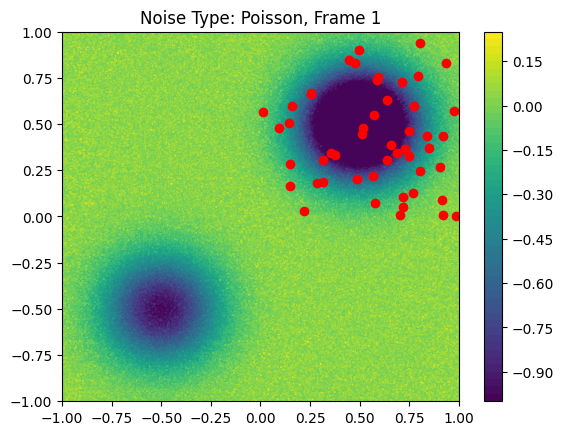

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)  # Contraindre x à l'intervalle [-1, 1]
    y = np.clip(X[:, 1], -1, 1)  # Contraindre y à l'intervalle [-1, 1]
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(lambda X: bimodal_function_2d_for_optimization(X, noise_type="poisson"), iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="poisson").reshape(X.shape)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)

def animate(frame):
    ax.clear()
    ax.set_title(f"Noise Type: Poisson, Frame {frame + 1}")
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type="poisson").reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)  # Assurez-vous que les particules restent dans les limites
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation11.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

#### All

2024-05-20 08:51:20,152 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 08:51:20,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.5672363  0.29946556]
2024-05-20 08:51:20,702 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 08:51:20,711 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpumfz87nk/temp.m4v


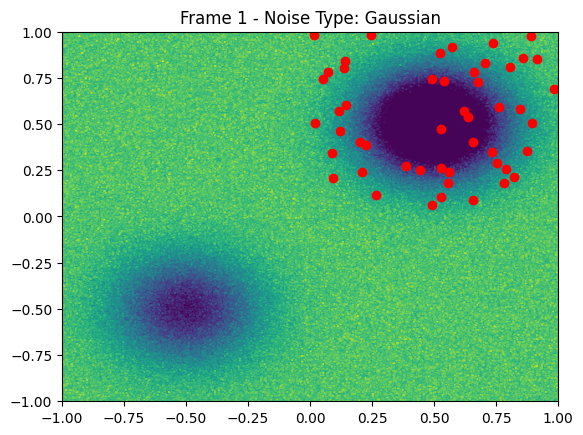

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)
    y = np.clip(X[:, 1], -1, 1)
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

class OptimizerWrapper:
    def __init__(self, optimizer, noise_schedule):
        self.optimizer = optimizer
        self.noise_schedule = noise_schedule
        self.iteration = 0

    def objective(self, X):
        noise_type = self.noise_schedule[self.iteration % len(self.noise_schedule)]
        self.iteration += 1
        return bimodal_function_2d_for_optimization(X, noise_type=noise_type)

# Create the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
wrapper = OptimizerWrapper(optimizer, ["gaussian", "uniform", "poisson", "sinusoidal"])

# Perform optimization
cost, pos = wrapper.optimizer.optimize(wrapper.objective, iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)

def animate(frame):
    ax.clear()
    current_noise = wrapper.noise_schedule[frame % len(wrapper.noise_schedule)]
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type=current_noise).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(wrapper.optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')
    ax.set_title(f"Frame {frame + 1} - Noise Type: {current_noise.capitalize()}")

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation7.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)

2024-05-20 09:15:47,470 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-05-20 09:15:47,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [0.67710136 0.42183083]
2024-05-20 09:15:48,190 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-20 09:15:48,202 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp37f_9a4o/temp.m4v


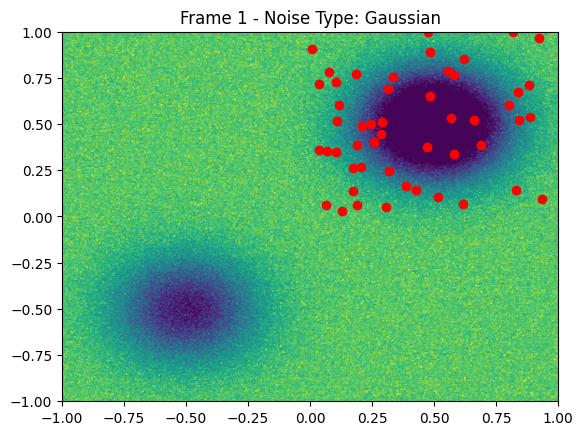

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pyswarms as ps

def generate_noise(noise_type, size):
    if noise_type == "gaussian":
        return np.random.normal(0, 0.1, size)
    elif noise_type == "uniform":
        return np.random.uniform(-0.1, 0.1, size)
    elif noise_type == "poisson":
        return np.random.poisson(5, size) * 0.02 - 0.1
    elif noise_type == "sinusoidal":
        return 0.1 * np.sin(np.linspace(0, 2 * np.pi, size))
    else:
        return np.zeros(size)

def bimodal_function_2d_for_optimization(X, noise_type="gaussian"):
    x = np.clip(X[:, 0], -1, 1)
    y = np.clip(X[:, 1], -1, 1)
    mu1 = [-0.5, -0.5]
    sigma1 = [0.2, 0.2]
    mu2 = [0.5, 0.5]
    sigma2 = [0.2, 0.2]
    gauss1 = np.exp(-((x - mu1[0])**2 / (2 * sigma1[0]**2) + (y - mu1[1])**2 / (2 * sigma1[1]**2)))
    gauss2 = np.exp(-((x - mu2[0])**2 / (2 * sigma2[0]**2) + (y - mu2[1])**2 / (2 * sigma2[1]**2)))
    result = -(gauss1 + 2 * gauss2)
    noise = generate_noise(noise_type, X.shape[0])
    result += noise
    return np.clip(result, -1, 1)

# Création d'une classe pour gérer les itérations et le type de bruit
class IterativeNoiseController:
    def __init__(self, noise_schedule):
        self.noise_schedule = noise_schedule
        self.iteration = 0

    def objective_function(self, X):
        # Calculer l'index de bruit basé sur l'itération actuelle
        index = self.iteration // 25
        self.iteration += 1
        return bimodal_function_2d_for_optimization(X, noise_type=self.noise_schedule[index])

# Initialisation du contrôleur de bruit
noise_types = ["gaussian", "uniform", "poisson", "sinusoidal"]
controller = IterativeNoiseController(noise_types)

# Configuration de l'optimiseur
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(controller.objective_function, iters=100)

fig, ax = plt.subplots()
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)

def animate(frame):
    ax.clear()
    current_noise = noise_types[(frame // 25) % len(noise_types)]  # Choisir le bruit selon la tranche de 25 frames
    Z = bimodal_function_2d_for_optimization(np.column_stack([X.ravel(), Y.ravel()]), noise_type=current_noise).reshape(X.shape)
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    particle_positions = np.array(optimizer.pos_history[frame])
    particle_positions = np.clip(particle_positions, -1, 1)
    ax.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red')
    ax.set_title(f"Frame {frame + 1} - Noise Type: {current_noise.capitalize()}")

ani = FuncAnimation(fig, animate, frames=100, repeat=False)

# Convertir l'animation en HTML5 Video et sauvegarder
html_code = ani.to_html5_video()
html_file_path = '/content/drive/My Drive/my_animation9.html'
with open(html_file_path, "w") as html_file:
    html_file.write(html_code)